In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import warnings
from pathlib import Path

#If you get an error either delete or add a parent
project_root = Path('.').resolve().parent.parent
sys.path.append(str(project_root))
print("Project root:", project_root)
print("Python path:", sys.path)

from tools import helpers as hp
from var import stationary as st
from tools import plotresults as pr
from deepvar import deepvar
from var import var
from deepvar import lstm
from deepvar import irf
import warnings 

warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

Project root: /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results
Python path: ['/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/bram/Library/Python/3.10/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def prepare_df(df):
    df['log_GDP'] = np.log(df['GDP']) 
    df['log_CPI'] = np.log(df['CPI']) 
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df

Basic VAR detrend results

In [20]:
df = pd.read_csv('../../Data/WithoutPolicyRate.csv')

variables_to_keep = ['log_GDP', 'household_debt']

In [21]:
df = prepare_df(df)
# pr_df = prepare_df(pr_df)
df = df.drop(columns = {"exchange_rate"})
df = df[variables_to_keep]
LAGS = 3


In [22]:
variables = df.columns
final_detrend = st.detrend_data(df, variables, 1) 
final_detrend = final_detrend[final_detrend.index.get_level_values("TIME_PERIOD")< "2020-03-31"]

Index(['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Ireland', 'Germany',
       'Brazil', 'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Argentina',
       'Singapore', 'France', 'Portugal', 'Hungary', 'Spain', 'Canada',
       'Switzerland', 'United States', 'Denmark', 'Indonesia',
       'China, P.R.: Hong Kong', 'Luxembourg', 'Japan', 'Finland',
       'South Africa', 'Chile', 'Czech Rep.', 'Poland, Rep. of',
       'Türkiye, Rep of', 'Korea, Rep. of', 'Belgium'],
      dtype='object', name='Country')


In [10]:
aic_lags = var.aic_test(final_detrend)

lag_range = range(min(aic_lags),max(aic_lags)+1)
lag_list = [x for x in lag_range]

In [11]:
train_dt_var, test_dt_var = hp.time_panel_split_predict(final_detrend)

demeaned_df, cross_sectional_means = deepvar.prepare_data_with_fixed_effects(final_detrend, variables = variables_to_keep)


lstm_df= lstm.create_lstm_data(demeaned_df, LAGS)

inputs = lstm.get_lstm_input(final_detrend, LAGS)
lstm_train, lstm_val, lstm_test= lstm.train_val_test_split(lstm_df)

lstm_df_window = lstm.create_lstm_data(demeaned_df, 1)
inputs_window = lstm.get_lstm_input(demeaned_df, 1)
lstm_train_window, lstm_val_window, lstm_test_window= lstm.train_val_test_split(lstm_df_window)


In [12]:
num_unique_countries = len(final_detrend.index.get_level_values("Country").unique())
print("Countries", num_unique_countries)
print("Number of obsevations", len(final_detrend))

Countries 39
Number of obsevations 4065


In [14]:

t, v, te = lstm.train_val_test_split(lstm_df, .85)
countries = t.index.get_level_values('Country').unique()
min_len = float('inf')
shortest_country = None

for country in countries:
    country_len = len(hp.get_country(v, country))
    if country_len < min_len:
        min_len = country_len
        shortest_country = country
min_len


6

In [16]:
def lstm_error_comparison(df, df_window, inputs_window, target, lag_range=(1, 8), min_lr=1e-4, max_lr=1e-1, num_epochs=500):
   
    num_elements = lag_range[1] - lag_range[0]
    
    errors = {
        "window_mse": ["" for _ in range(num_elements)],
        "no_window_mse": ["" for _ in range(num_elements)],
        "window_rmse": ["" for _ in range(num_elements)],
        "no_window_rmse": ["" for _ in range(num_elements)],
        "window_mae": ["" for _ in range(num_elements)],
        "no_window_mae": ["" for _ in range(num_elements)]
    }
    
    index_labels = [f"{i}" for i in range(lag_range[0], lag_range[1])]
    
    errors_df = pd.DataFrame(errors, index=index_labels)
    
    # Loop through each lag
    for lag in range(lag_range[0], lag_range[1]):
        lstm_df = lstm.create_lstm_data(df, lag)
        inputs = lstm.get_lstm_input(df, lag)
        best_lr = lstm.find_learning_rate(lstm_df, inputs, target, min_lr=min_lr, max_lr=max_lr)
        model, predictions, metrics, scaler_X, scaler_y = lstm.train_lstm_model(lstm_df, inputs, [target], best_lr, num_epochs=num_epochs)
        best_lr_window = lstm.find_learning_rate(df_window, inputs_window, target, min_lr=min_lr, max_lr=max_lr)
        model_window, predictions_window, metrics_window, scaler_X_window, scaler_y_window = lstm.train_lstm_model_windows(
            df_window, inputs_window, [target], learning_rate=best_lr_window, num_epochs=num_epochs, windows=lag
        )
        
        errors_df.loc[f"{lag}", "no_window_mse"] = metrics[0]
        errors_df.loc[f"{lag}", "no_window_rmse"] = metrics[1]
        errors_df.loc[f"{lag}", "no_window_mae"] = metrics[2]
        errors_df.loc[f"{lag}", "window_mse"] = metrics_window[0]
        errors_df.loc[f"{lag}", "window_rmse"] = metrics_window[1]
        errors_df.loc[f"{lag}", "window_mae"] = metrics_window[2]
        
    return errors_df


def plot_comparison(df, metrics=['mse', 'rmse', 'mae'], 
                   titles=['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)'],
                   figsize=(12, 15), 
                   window_color='#3498db', no_window_color='#e74c3c'):

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    plt.style.use('seaborn-v0_8-whitegrid')
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['axes.titlesize'] = 14
    mpl.rcParams['axes.labelsize'] = 13
    
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True, facecolor='#f9f9f9')
    fig.suptitle('Comparison of Error Metrics With and Without Window', fontsize=16, y=0.98)
    
    #loop through each metric
    for i, metric in enumerate(metrics):
        window_col = f'window_{metric}'
        no_window_col = f'no_window_{metric}'
        
        x = np.arange(len(df.index))
        width = 0.35
        
        bars1 = axes[i].bar(x - width/2, df[window_col], width,
                         label='With Window', color=window_color, alpha=0.8,
                         edgecolor='white', linewidth=0.7)
        
        bars2 = axes[i].bar(x + width/2, df[no_window_col], width,
                          label='No Window', color=no_window_color, alpha=0.8,
                          edgecolor='white', linewidth=0.7)
        
        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                axes[i].annotate(f'{height:.2f}',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),  
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=10)
        
        add_labels(bars1)
        add_labels(bars2)
        
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(df.index)
        axes[i].set_title(titles[i], pad=15, fontweight='bold')
        axes[i].set_ylabel(metric.upper(), fontweight='bold')
        axes[i].grid(True, linestyle='--', alpha=0.3, axis='y')
        axes[i].set_facecolor('#f5f5f5')
        axes[i].legend(frameon=True, fancybox=True, shadow=True, loc='upper right')
        
        
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    
    axes[2].set_xlabel('Test Case', fontweight='bold')
    
    plt.tight_layout(pad=3)
    plt.subplots_adjust(top=0.94)  
    plt.show()


## Get Metrics for Log_GDP


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 69.78it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:01, 49.39it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at /

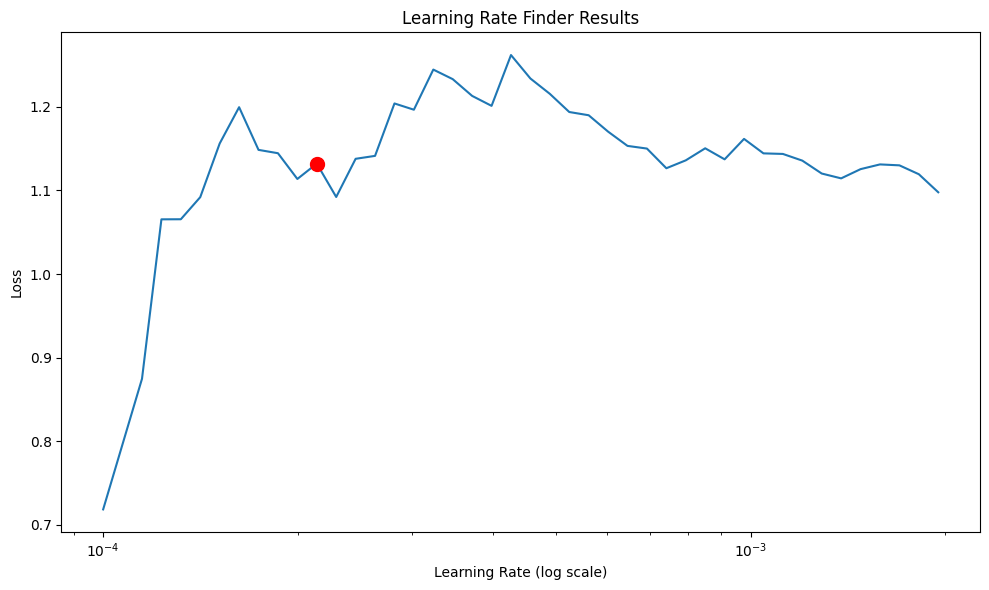

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU avai

Finding optimal learning rate...


Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 88.95it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 88.14it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_3c39d0e6-c820-4edb-b11f-82c12a197094.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_3c39d0e6-c820-4edb-b11f-82c12a197094.ckpt


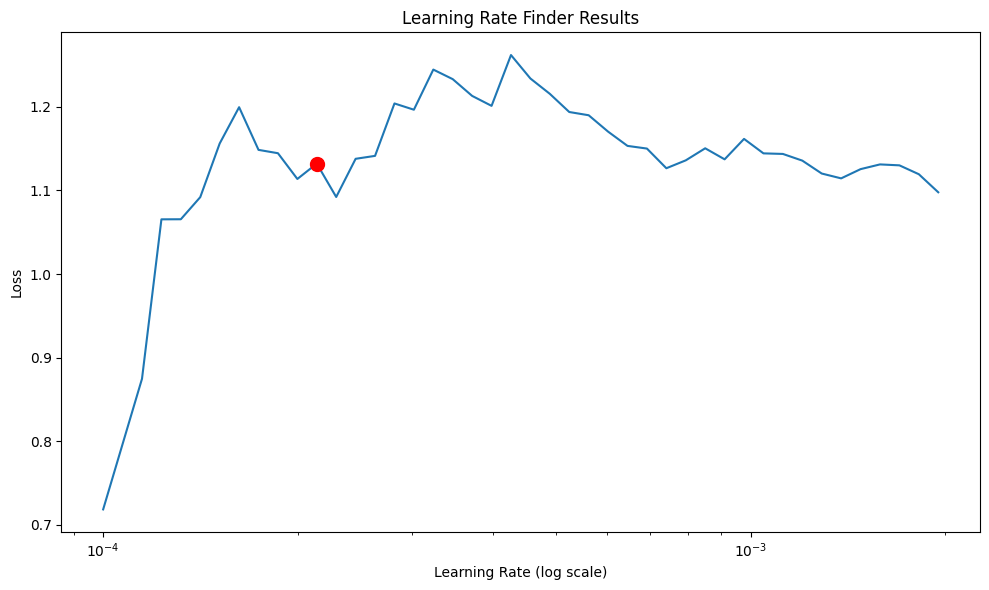

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 89.24it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 42 steps due to diverging loss.
Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 72.30it/s]
Learning rate set to 0.0002818382931264454
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_82326fc5-af63-447e-948a-14f1090713bb.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_82326fc5-af63-447e-948a-14f1090713bb.ckpt


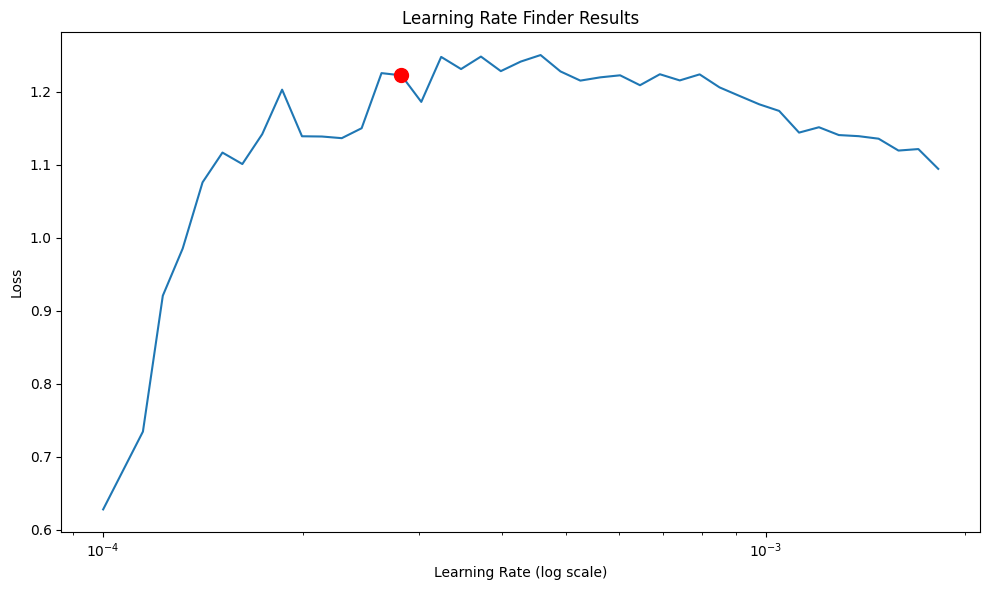

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00028184


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU avai

Finding optimal learning rate...


Finding best initial lr:  33%|███▎      | 33/100 [00:00<00:00, 100.84it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 101.07it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_f4b1a6ee-7ab3-459f-9dd3-e19d88f11e64.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_f4b1a6ee-7ab3-459f-9dd3-e19d88f11e64.ckpt


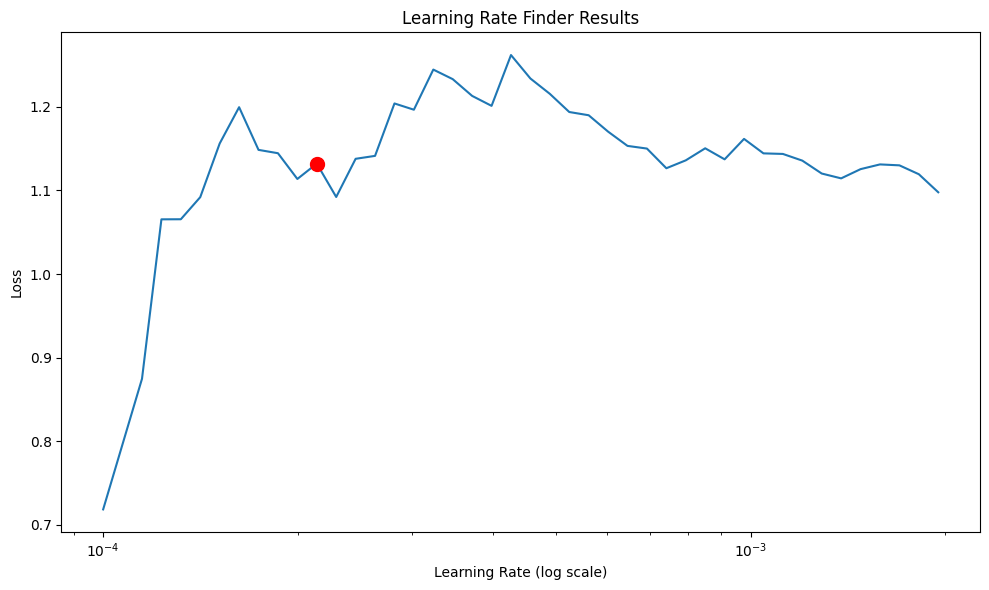

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


Finding best initial lr:  37%|███▋      | 37/100 [00:00<00:00, 93.56it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 75.96it/s]
Learning rate set to 0.0002818382931264454
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_acda1b18-ef7f-4f68-9e30-d163cf273f45.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_acda1b18-ef7f-4f68-9e30-d163cf273f45.ckpt


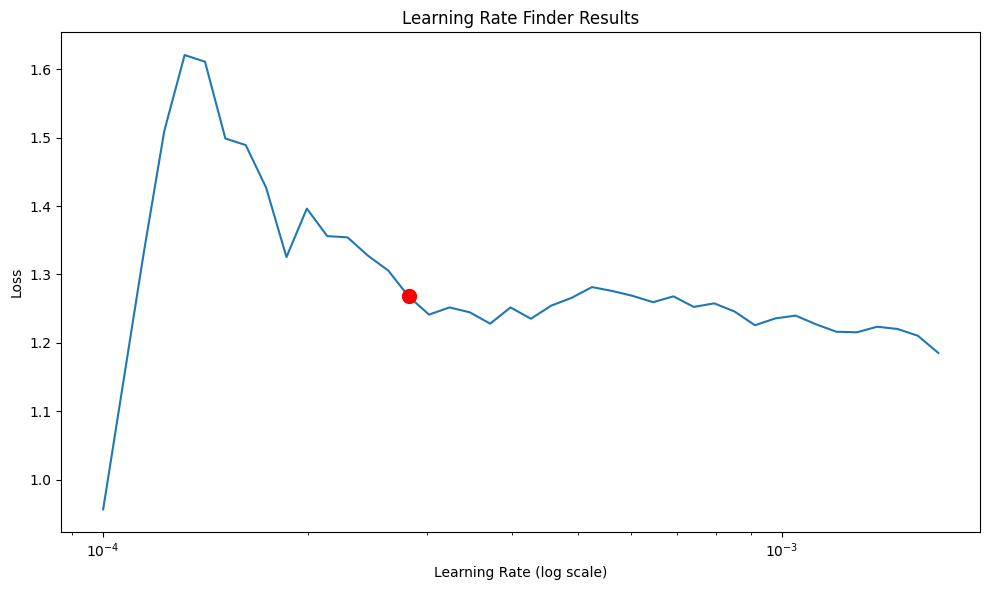

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00028184


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU avai

Finding optimal learning rate...


Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 89.60it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 90.43it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_b8f8d6d9-8e6d-4478-905c-93bef9cb5671.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_b8f8d6d9-8e6d-4478-905c-93bef9cb5671.ckpt


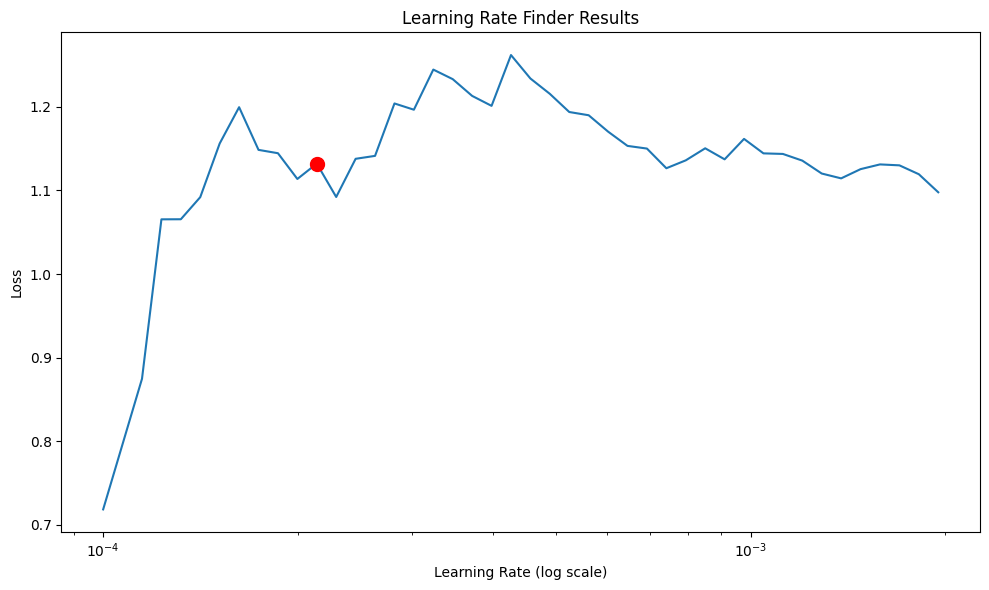

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


Finding best initial lr:  34%|███▍      | 34/100 [00:00<00:00, 85.15it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 70.39it/s]
Learning rate set to 0.00024547089156850307
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_cc4f19c2-d2bb-4de3-98f2-40add8857c57.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_cc4f19c2-d2bb-4de3-98f2-40add8857c57.ckpt


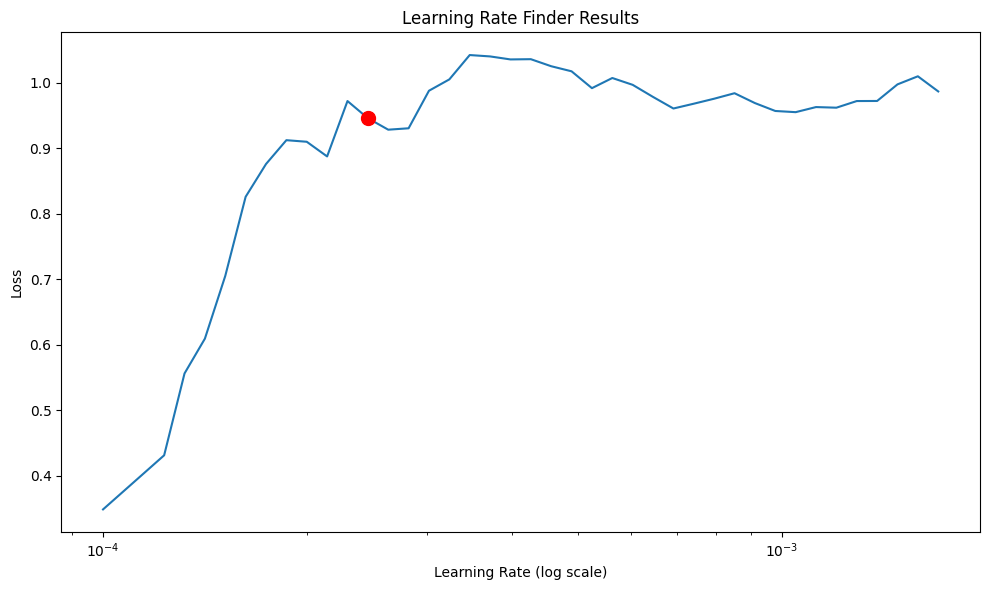

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00024547


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU avai

Finding optimal learning rate...


Finding best initial lr:  33%|███▎      | 33/100 [00:00<00:00, 100.78it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 100.71it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_698eb4cc-7b22-4a13-82c8-de074f8cc8f0.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_698eb4cc-7b22-4a13-82c8-de074f8cc8f0.ckpt


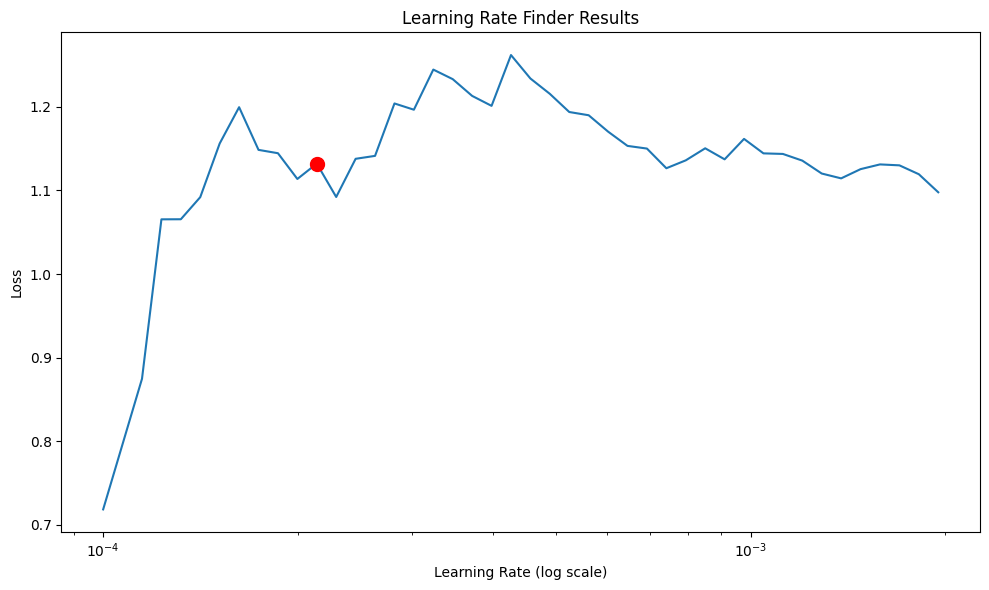

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


Finding best initial lr:  38%|███▊      | 38/100 [00:00<00:00, 96.03it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 77.26it/s]
Learning rate set to 0.00026302679918953825
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_64a016a3-0b37-4326-ac38-e23b2c54bc1b.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_64a016a3-0b37-4326-ac38-e23b2c54bc1b.ckpt


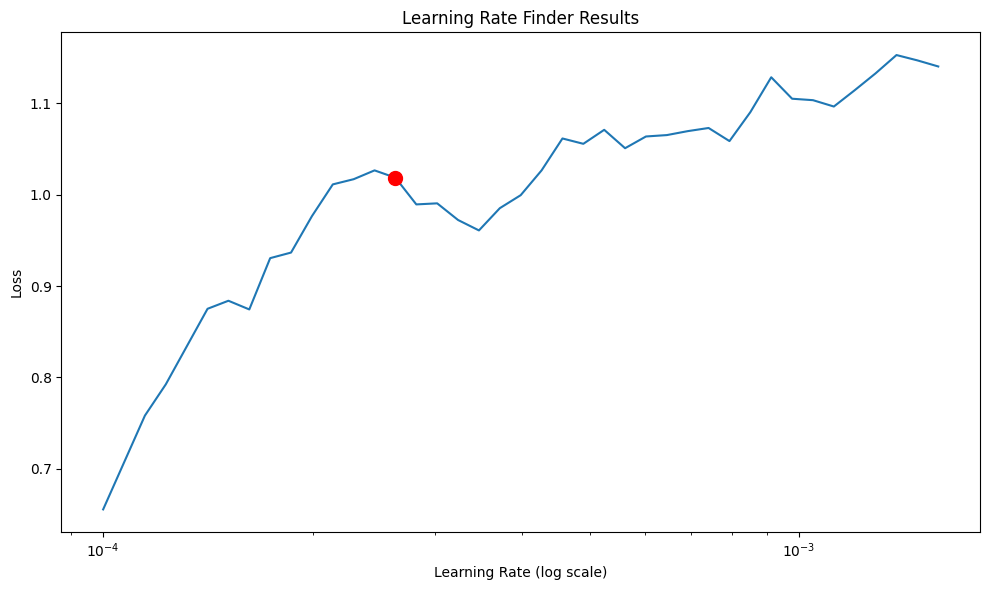

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00026303


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU avai

Finding optimal learning rate...


Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 97.66it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 97.51it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_879b9adf-ebd1-4421-b6d4-2535e058f212.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_879b9adf-ebd1-4421-b6d4-2535e058f212.ckpt


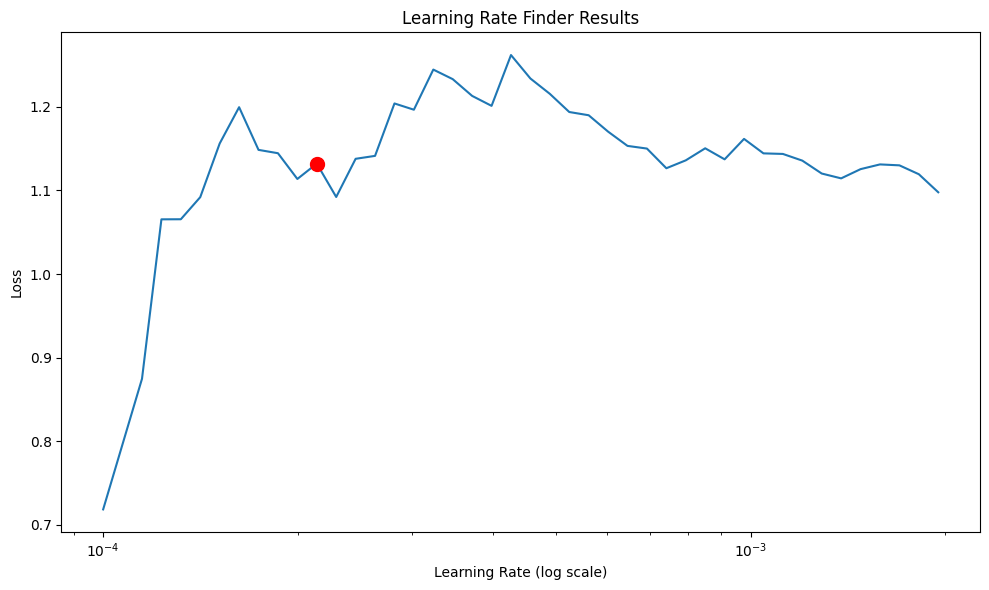

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


Finding best initial lr:  38%|███▊      | 38/100 [00:00<00:00, 95.80it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 75.00it/s]
Learning rate set to 0.0005623413251903491
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_c1aba9dd-5bd6-435e-835b-aad0dc698d2d.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_c1aba9dd-5bd6-435e-835b-aad0dc698d2d.ckpt


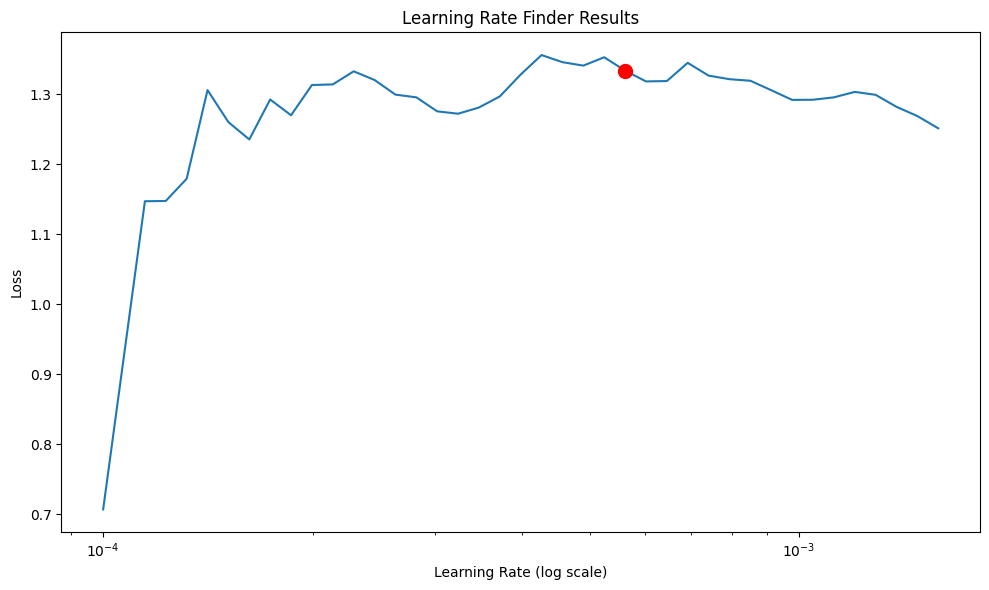

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00056234


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU avai

Finding optimal learning rate...


Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 101.43it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 100.66it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_5ab95826-f310-4030-949b-657e7000b283.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_5ab95826-f310-4030-949b-657e7000b283.ckpt


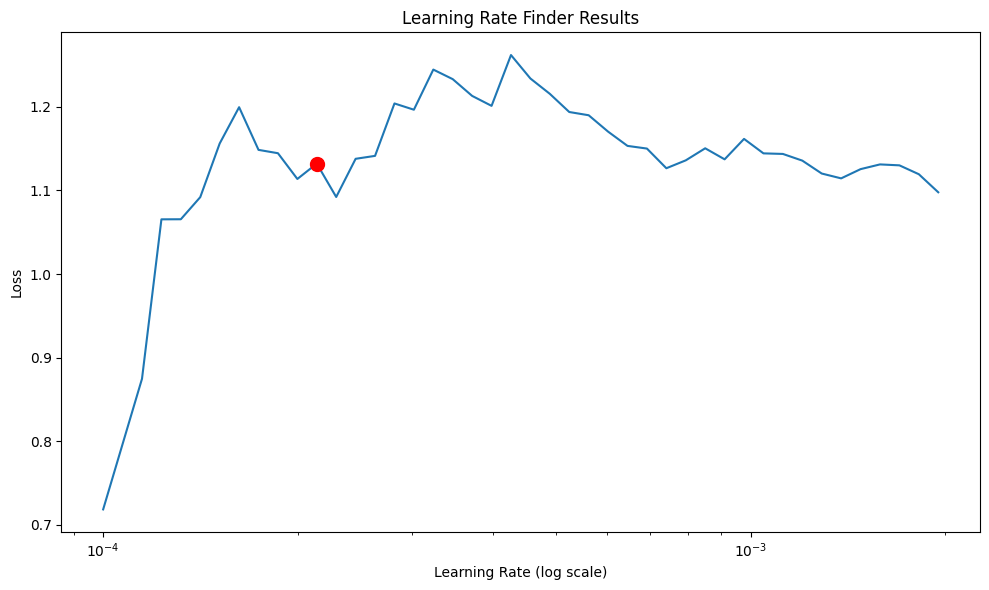

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

In [17]:
lGDP_errors_df = lstm_error_comparison(final_detrend, lstm_df_window, inputs_window, 'log_GDP', lag_range=(1, 7), min_lr=1e-4, max_lr=1e-1, num_epochs=500)



## Get Metrics for Household Debt

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  34%|███▍      | 34/100 [00:00<00:00, 105.23it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 105.82it/s]
Learning rate set to 0.0014791083881682077
Restoring states from the checkpoint path at 

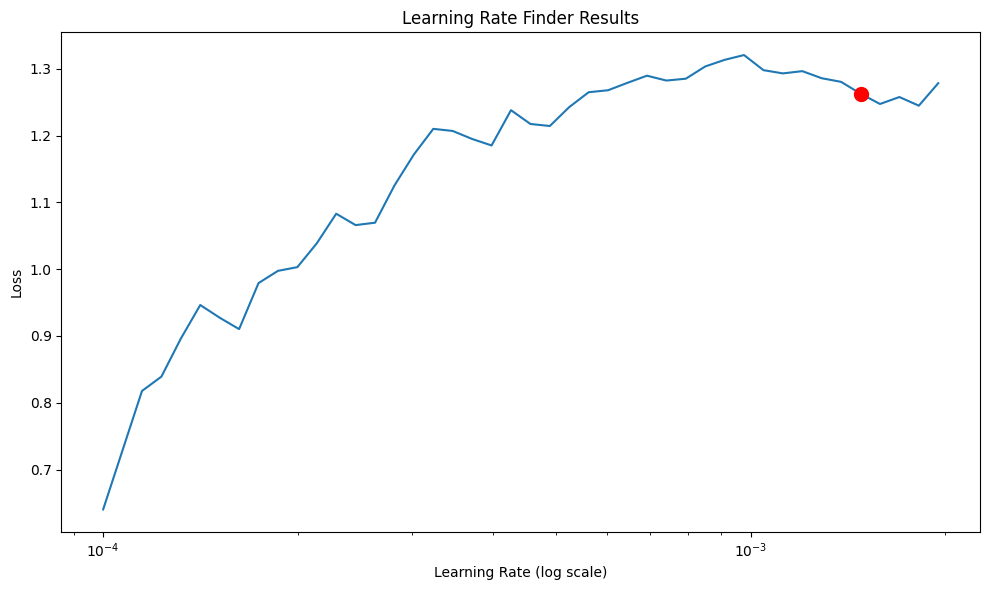

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00147911


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  43%|████▎     | 43/100 [00:01<00:01, 33.53it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:01<00:02, 28.03it/s]
Learning rate set to 0.0014791083881682077
Restoring states from the checkpoint path at /U

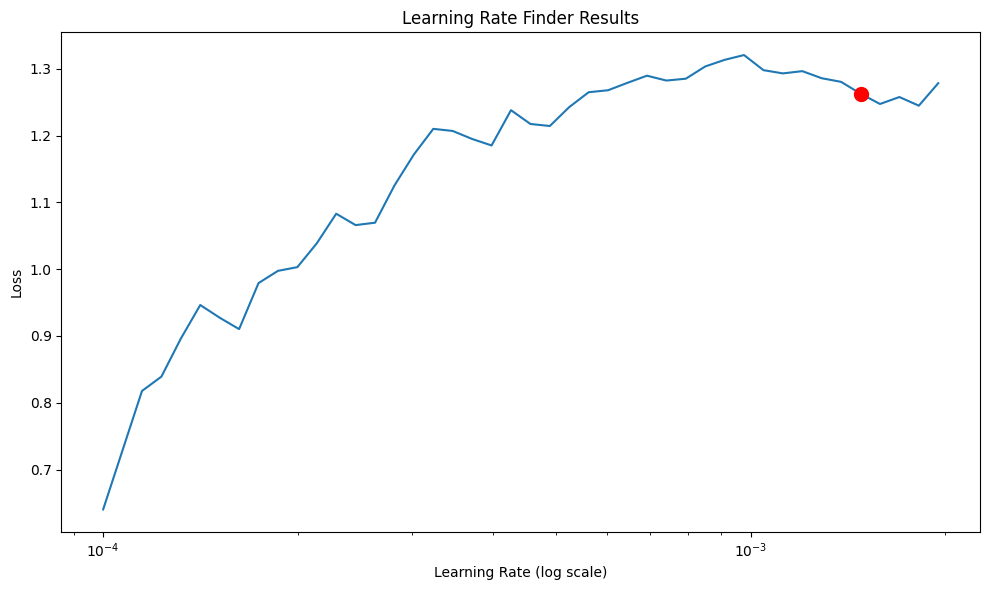

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00147911


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  33%|███▎      | 33/100 [00:00<00:00, 103.77it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 42 steps due to diverging loss.
Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 102.51it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at

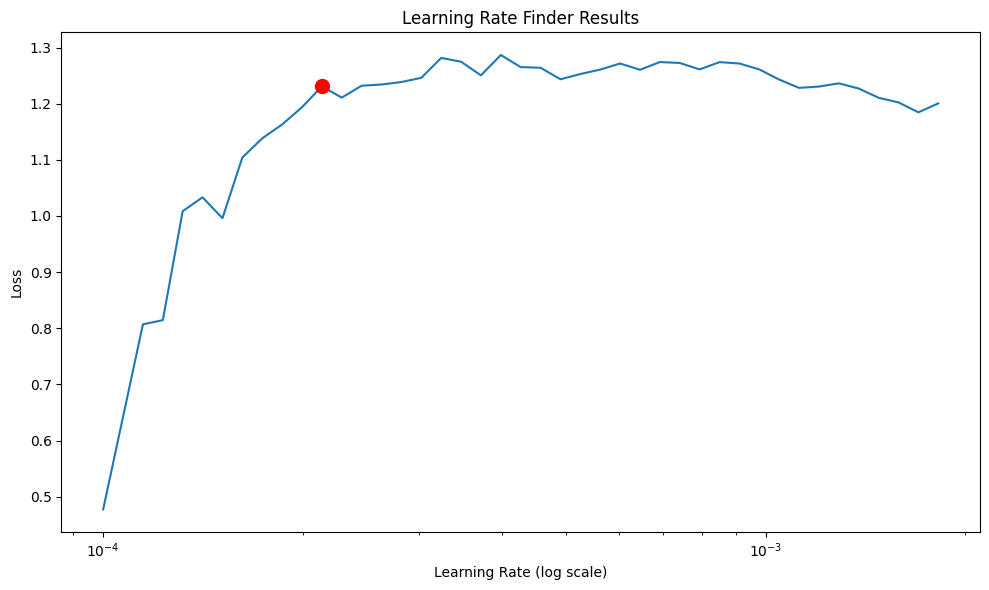

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  39%|███▉      | 39/100 [00:01<00:01, 31.43it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:01<00:01, 35.22it/s]
Learning rate set to 0.0014791083881682077
Restoring states from the checkpoint path at /U

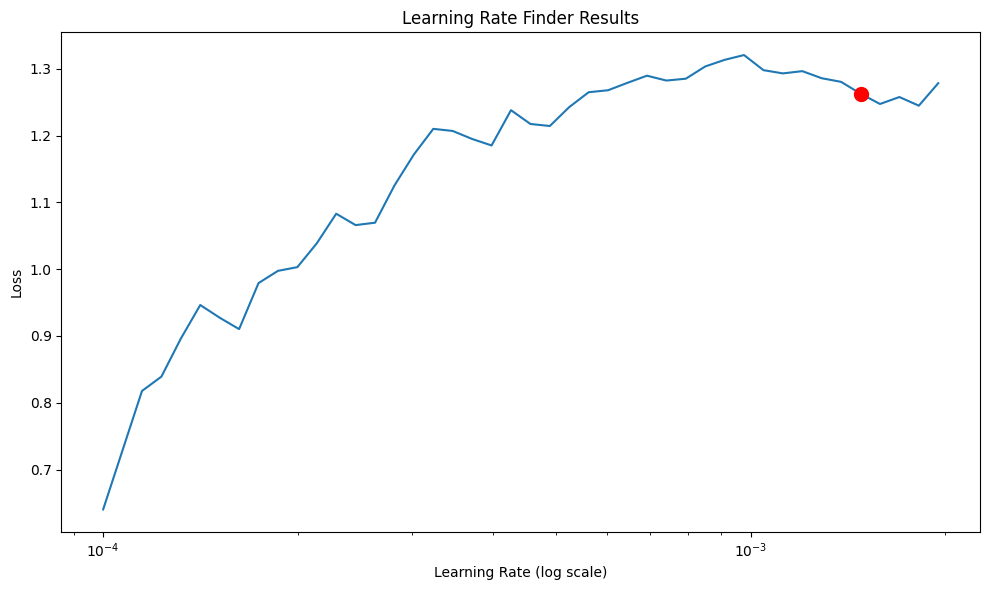

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00147911


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  32%|███▏      | 32/100 [00:00<00:00, 102.15it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 101.63it/s]
Learning rate set to 0.0015848931924611136
Restoring states from the checkpoint path at 

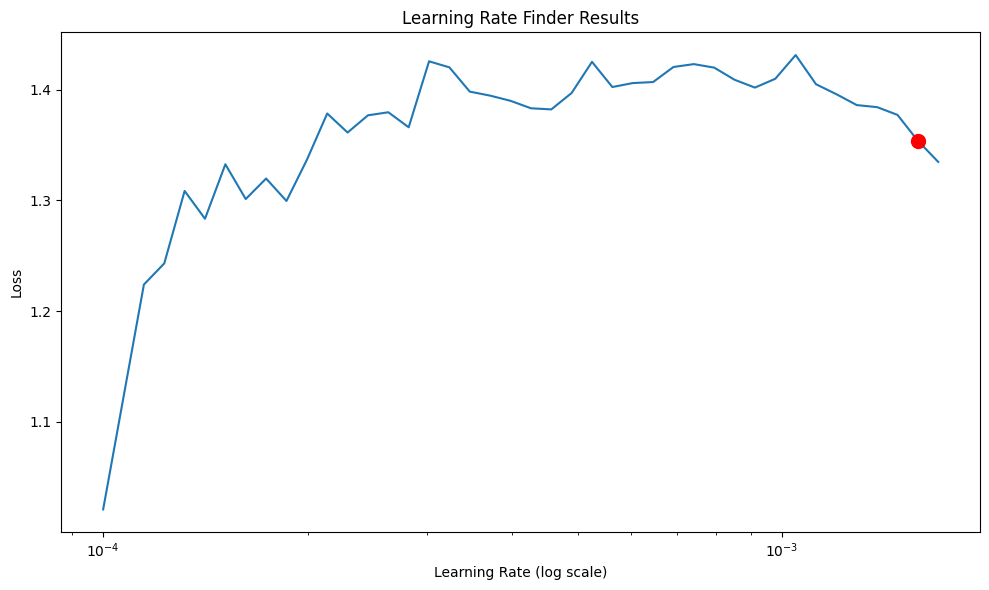

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00158489


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 96.72it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 95.93it/s]
Learning rate set to 0.0014791083881682077
Restoring states from the checkpoint path at /U

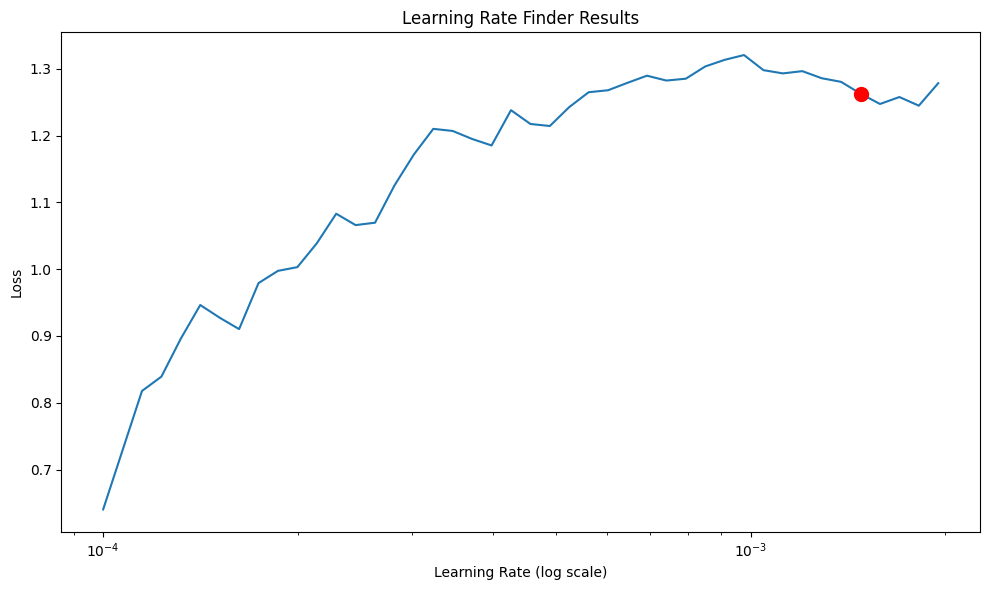

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00147911


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  32%|███▏      | 32/100 [00:00<00:00, 101.28it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 99.24it/s] 
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at

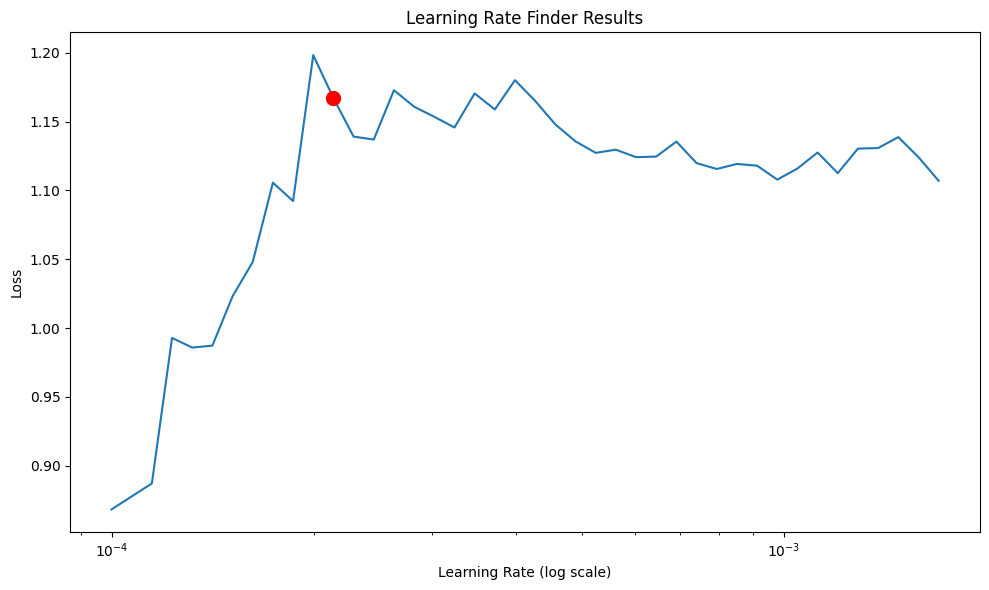

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  33%|███▎      | 33/100 [00:00<00:00, 105.49it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 104.83it/s]
Learning rate set to 0.0014791083881682077
Restoring states from the checkpoint path at 

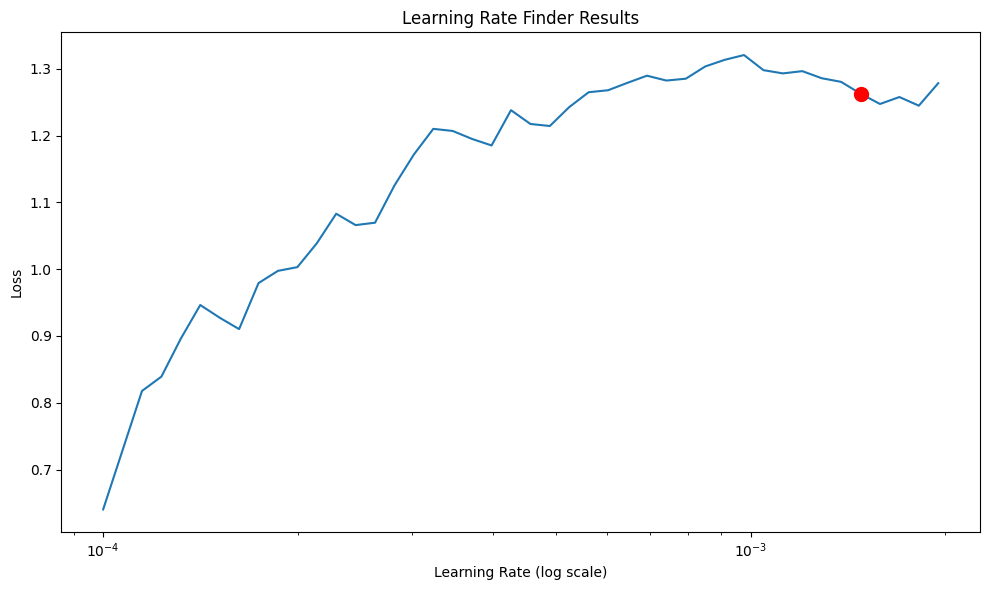

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00147911


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  33%|███▎      | 33/100 [00:00<00:00, 105.12it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 103.92it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at

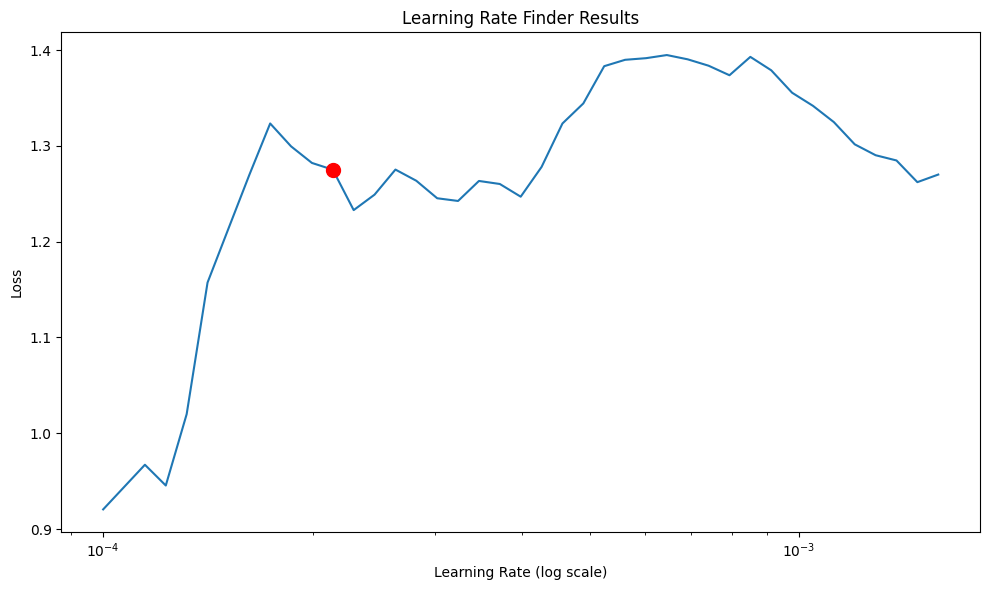

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 91.40it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 84.44it/s]
Learning rate set to 0.0014791083881682077
Restoring states from the checkpoint path at /U

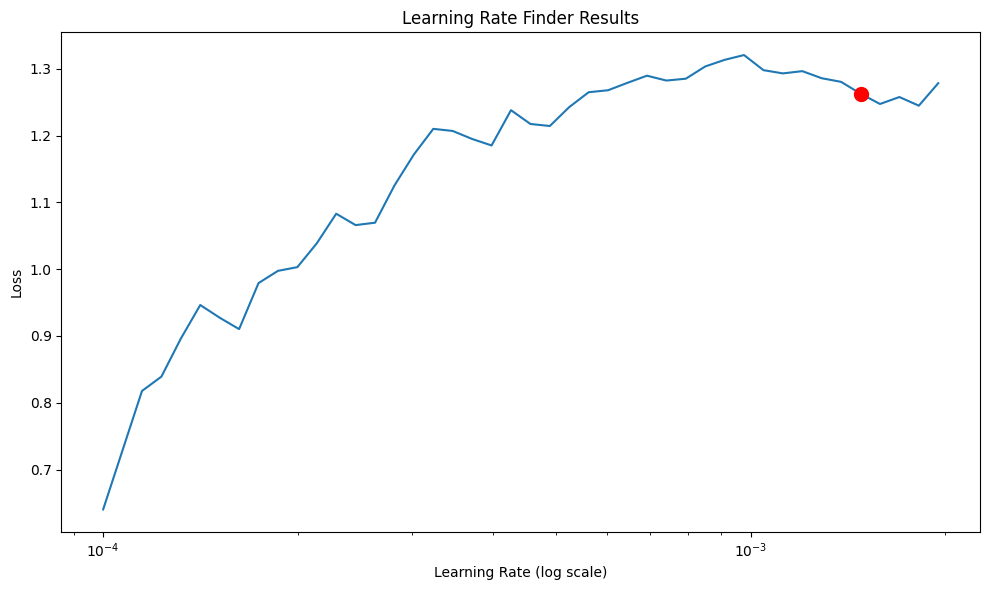

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00147911


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  33%|███▎      | 33/100 [00:00<00:00, 104.13it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 103.02it/s]
Learning rate set to 0.0007943282347242814
Restoring states from the checkpoint path at 

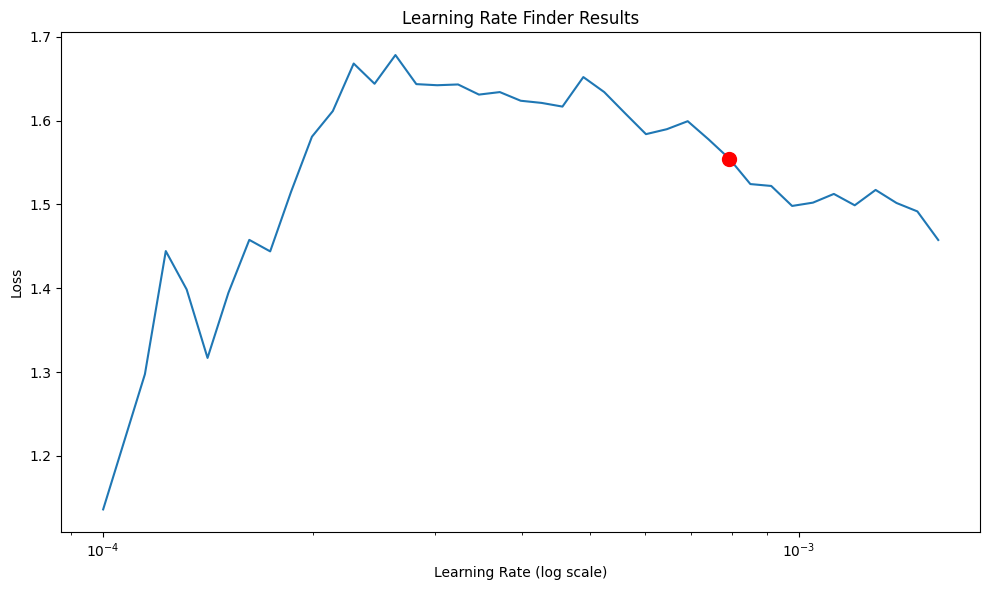

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00079433


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  43%|████▎     | 43/100 [00:01<00:02, 28.16it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:01<00:02, 27.25it/s]
Learning rate set to 0.0014791083881682077
Restoring states from the checkpoint path at /U

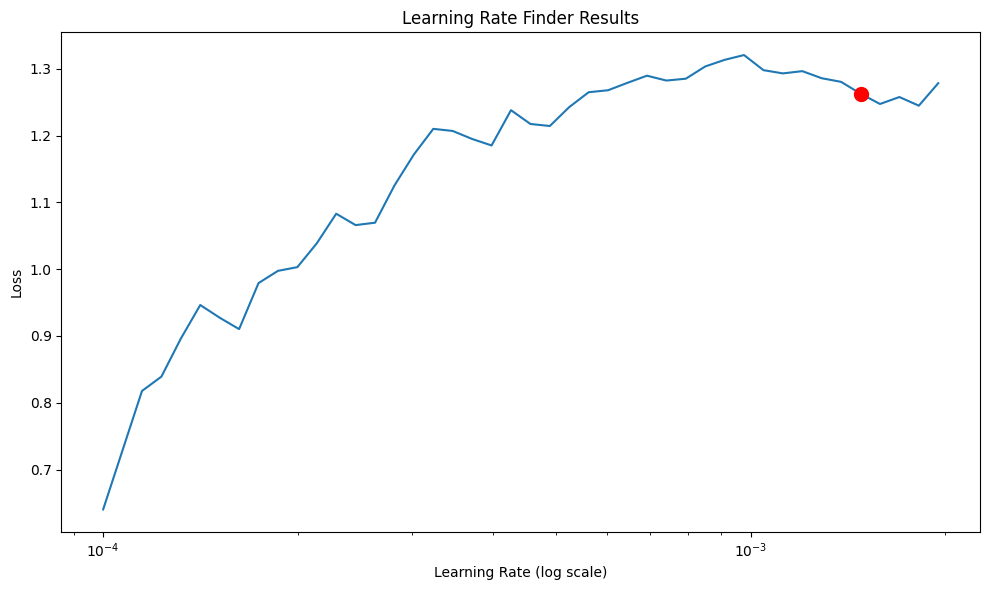

Suggested learning rate: 0.00147911


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoad

In [12]:
hhd_errors_df = lstm_error_comparison(final_detrend, lstm_df_window, inputs_window, 'household_debt', lag_range=(1, 7), min_lr=1e-4, max_lr=1e-1, num_epochs=500)


## Get Metrics for Private Debt

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  41%|████      | 41/100 [00:01<00:01, 37.71it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:01<00:01, 38.98it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at /U

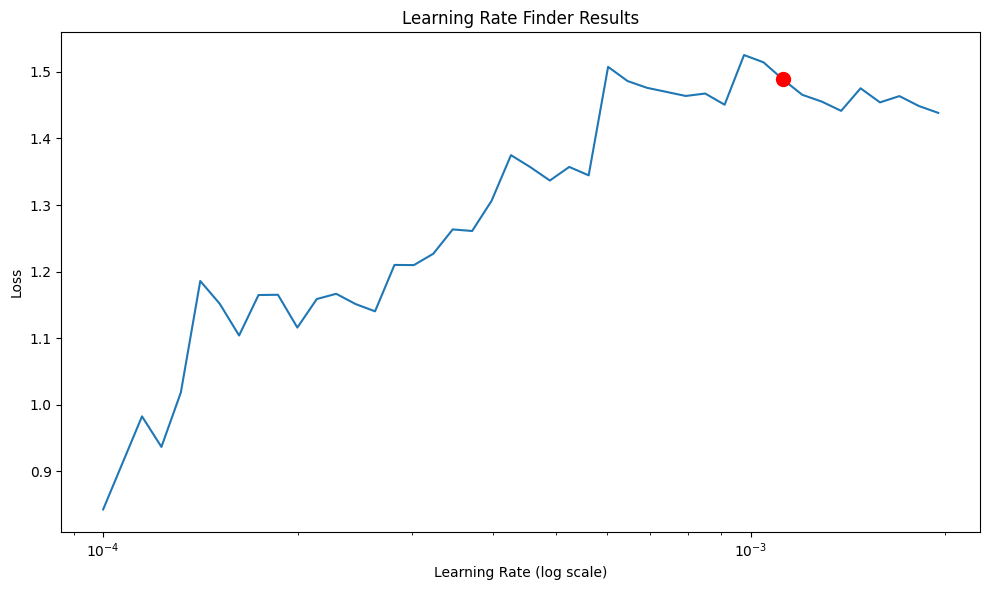

Suggested learning rate: 0.00112202


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoad

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 110.69it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 110.40it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

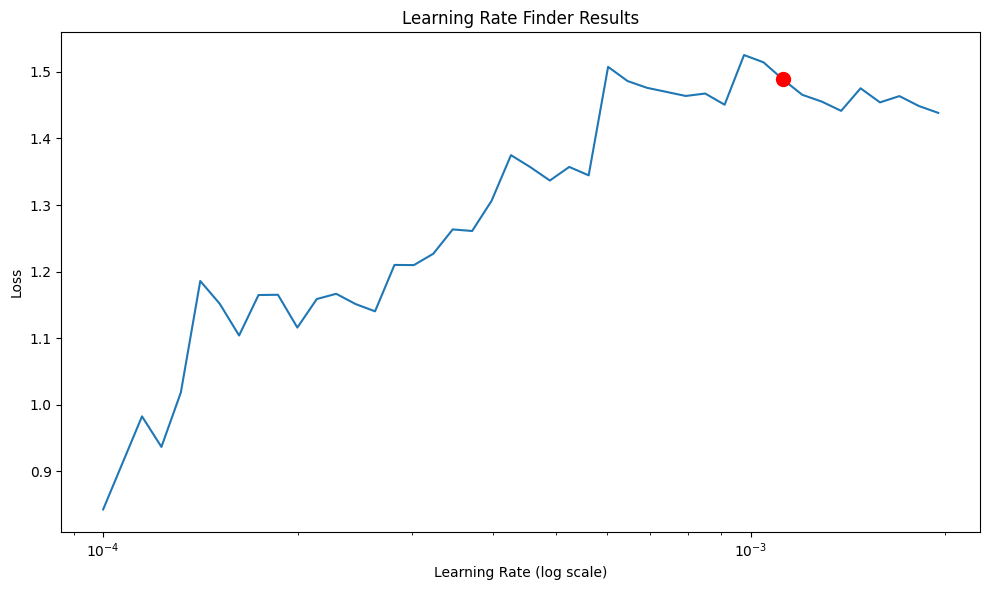

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  34%|███▍      | 34/100 [00:00<00:00, 109.14it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 42 steps due to diverging loss.
Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 108.16it/s]
Learning rate set to 0.0005248074602497726
Restoring states from the checkpoint path at 

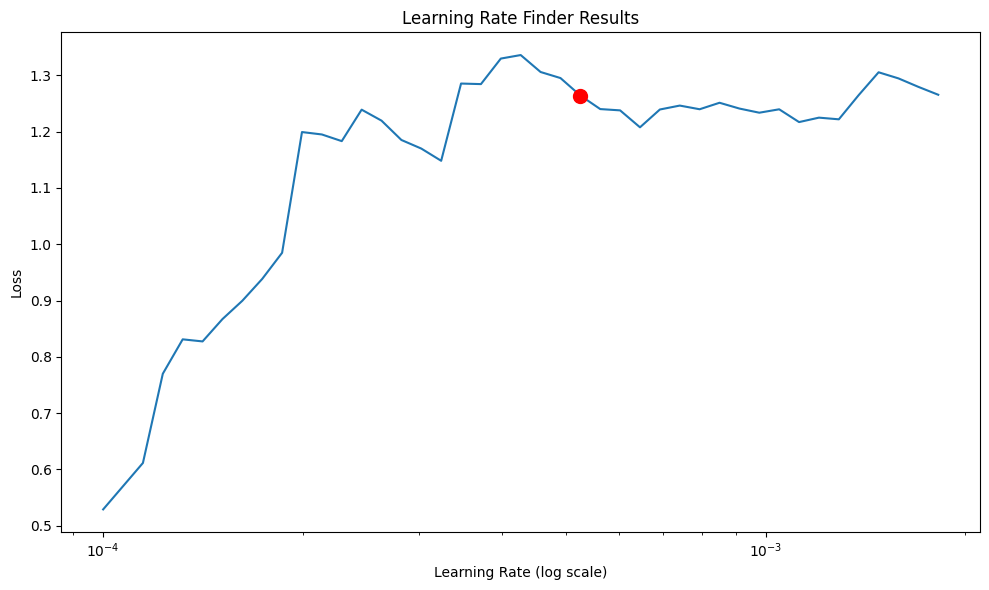

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00052481


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 112.48it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 113.10it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

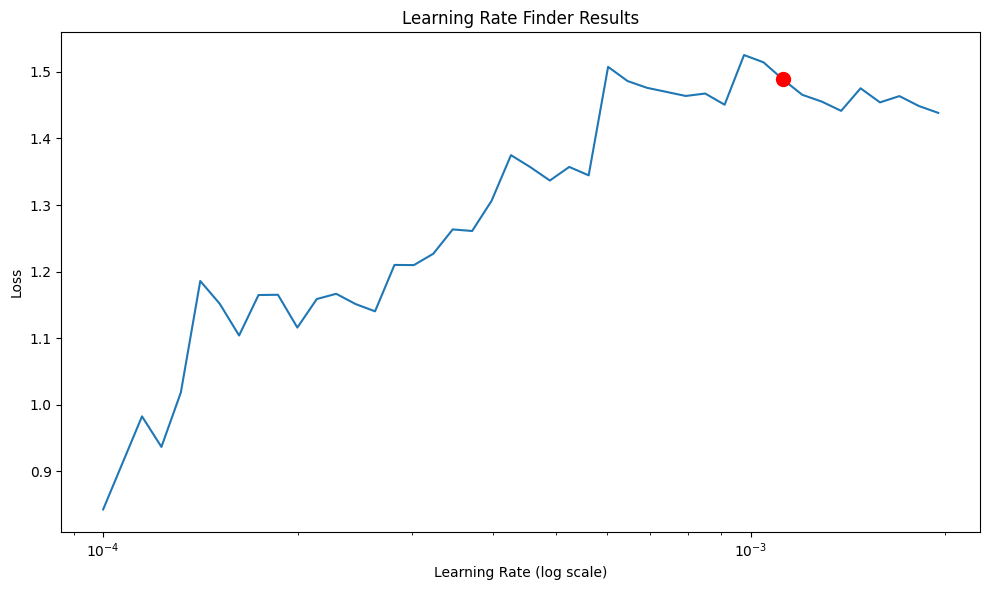

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 112.71it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 109.98it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at

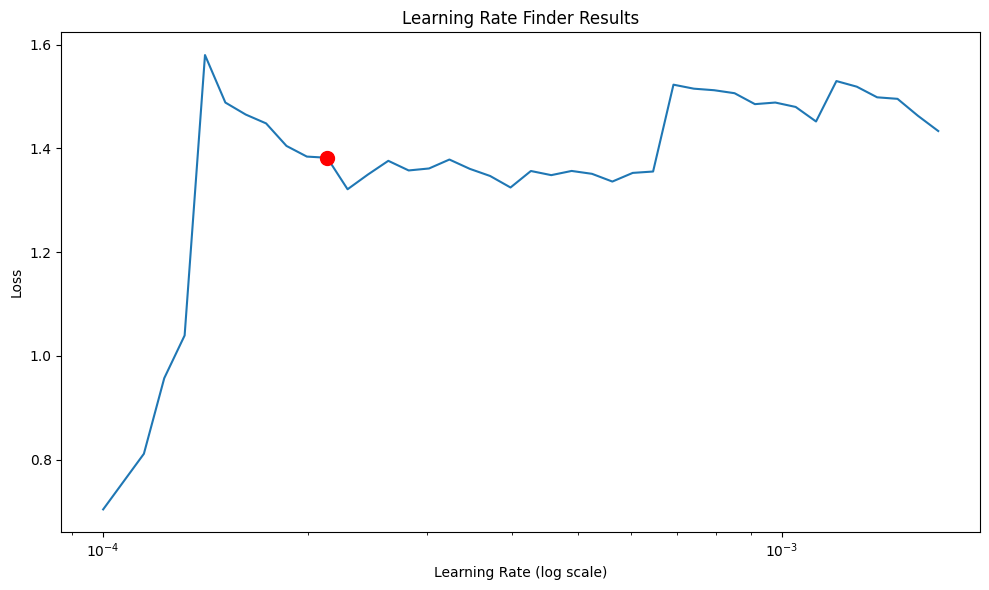

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 113.18it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 113.18it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

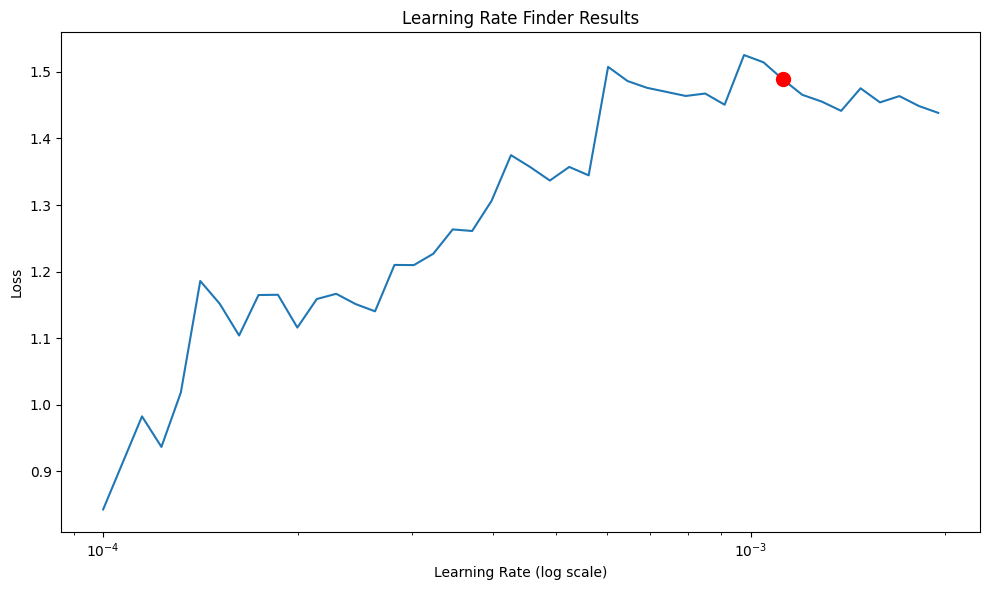

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 116.46it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 112.96it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at

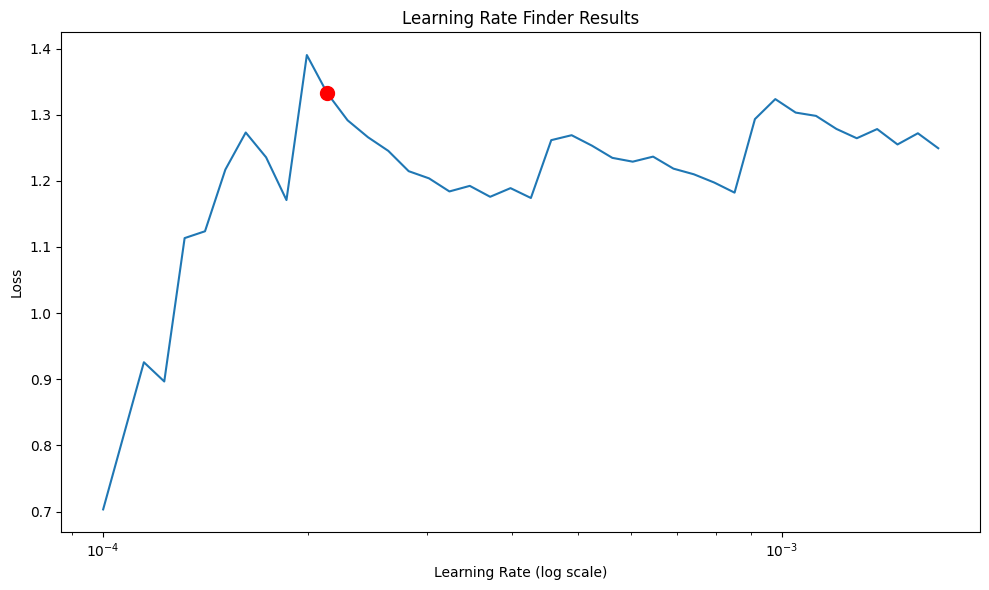

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  33%|███▎      | 33/100 [00:00<00:00, 106.90it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 104.64it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

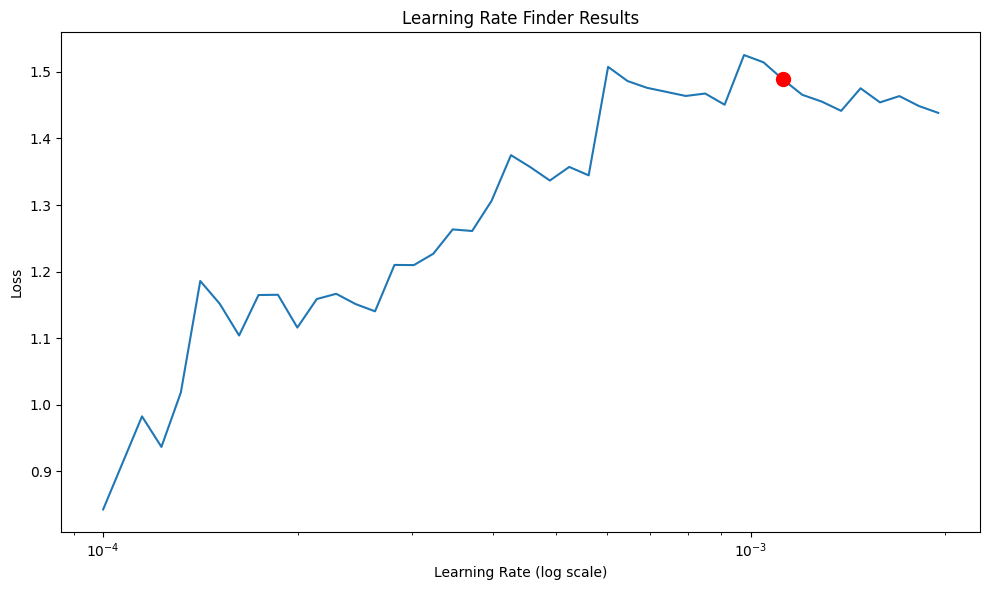

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  34%|███▍      | 34/100 [00:00<00:00, 110.91it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 105.25it/s]
Learning rate set to 0.0009120108393559099
Restoring states from the checkpoint path at 

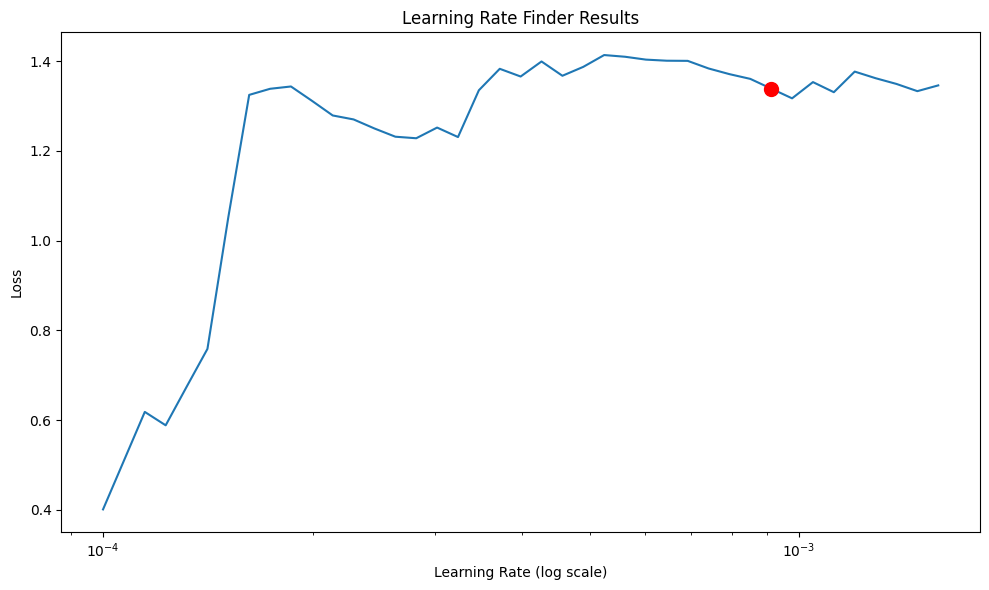

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00091201


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 103.08it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 101.60it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

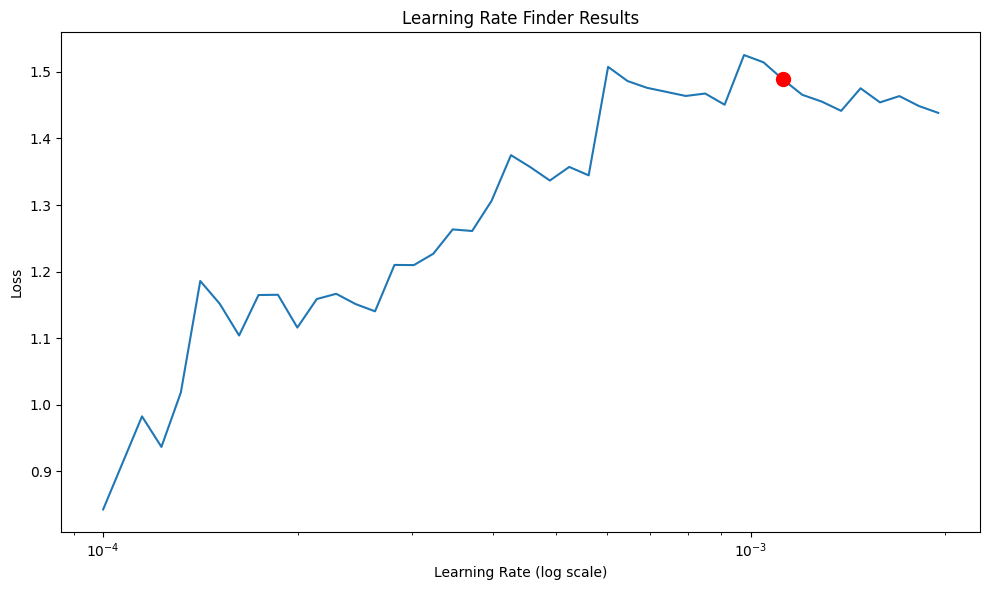

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 100.12it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 98.26it/s] 
Learning rate set to 0.00024547089156850307
Restoring states from the checkpoint path at

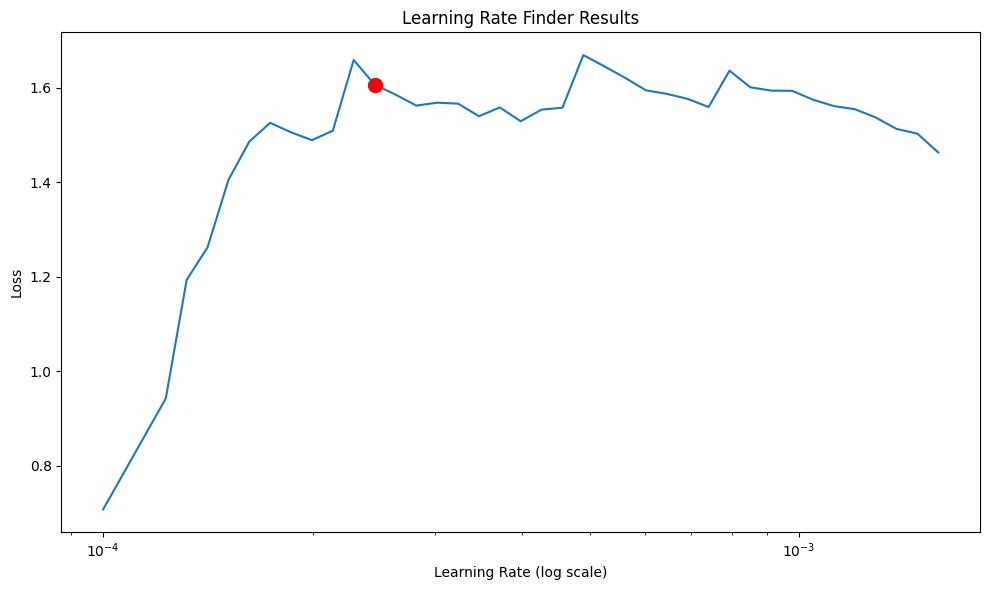

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00024547


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  43%|████▎     | 43/100 [00:01<00:01, 38.99it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:01<00:01, 38.71it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at /U

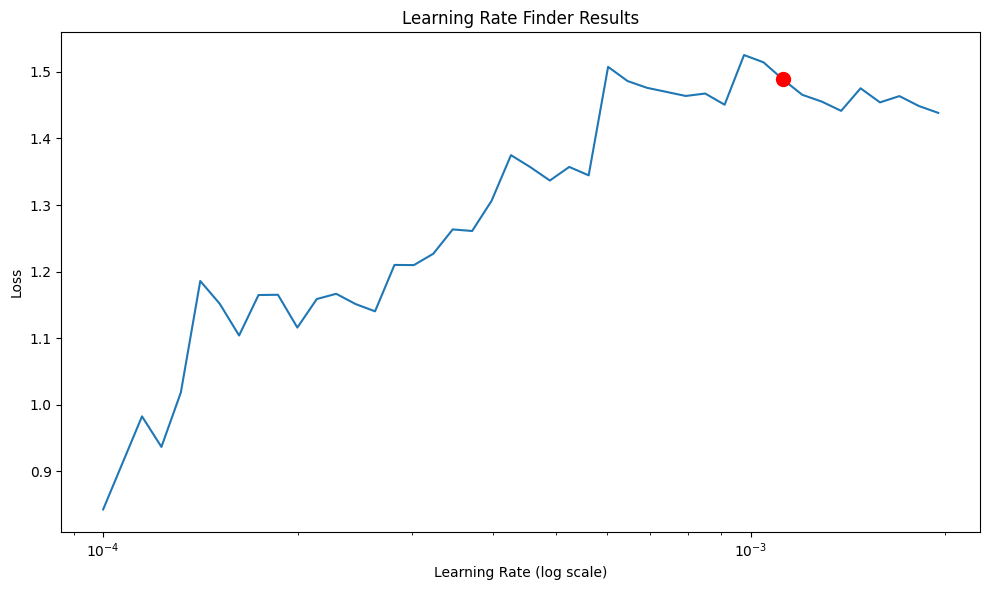

Suggested learning rate: 0.00112202


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoad

In [13]:
private_debt_errors_df = lstm_error_comparison(final_detrend, lstm_df_window, inputs_window, 'private_debt', lag_range=(1, 7), min_lr=1e-4, max_lr=1e-1, num_epochs=500)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding optimal learning rate...


Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 90.74it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 86.96it/s]
Learning rate set to 0.0010471285480508998
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_b863213a-1ced-4347-a74e-947ad0658dec.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_b863213a-1ced-4347-a74e-947ad0658dec.ckpt


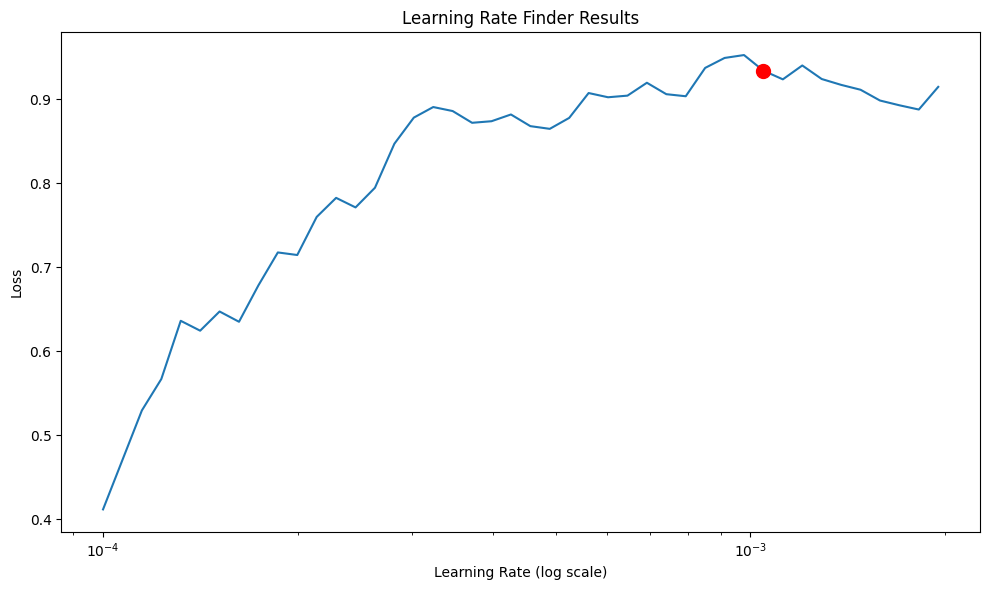

Suggested learning rate: 0.00104713


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoad

Finding optimal learning rate...


Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 95.76it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 95.13it/s]
Learning rate set to 0.0010471285480508998
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_55363e28-6f50-4465-8ab7-a4dcd54e39d0.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_55363e28-6f50-4465-8ab7-a4dcd54e39d0.ckpt


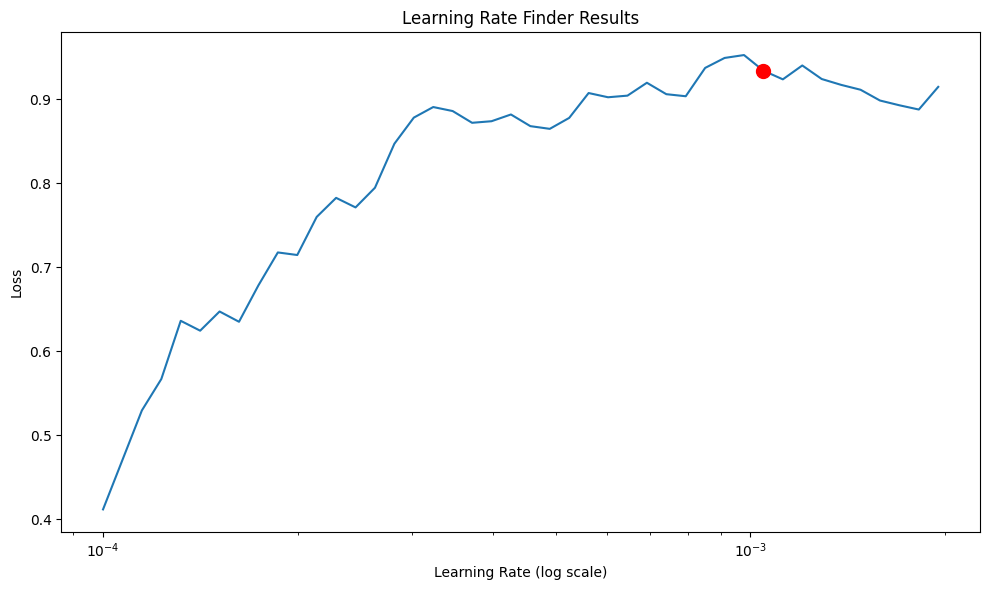

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00104713


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

NameError: name 'exit' is not defined

In [19]:
hhd_errors_df = lstm_error_comparison(final_detrend, lstm_df_window, inputs_window, 'household_debt', lag_range=(1, 7), min_lr=1e-4, max_lr=1e-1, num_epochs=500)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  33%|███▎      | 33/100 [00:00<00:00, 101.11it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 101.52it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

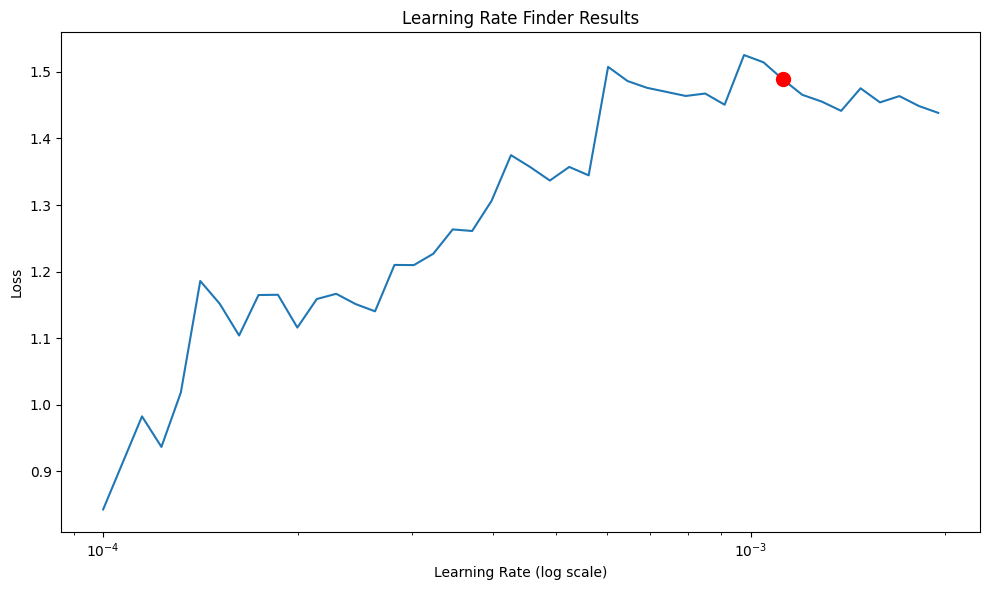

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  37%|███▋      | 37/100 [00:00<00:00, 119.20it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 118.29it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

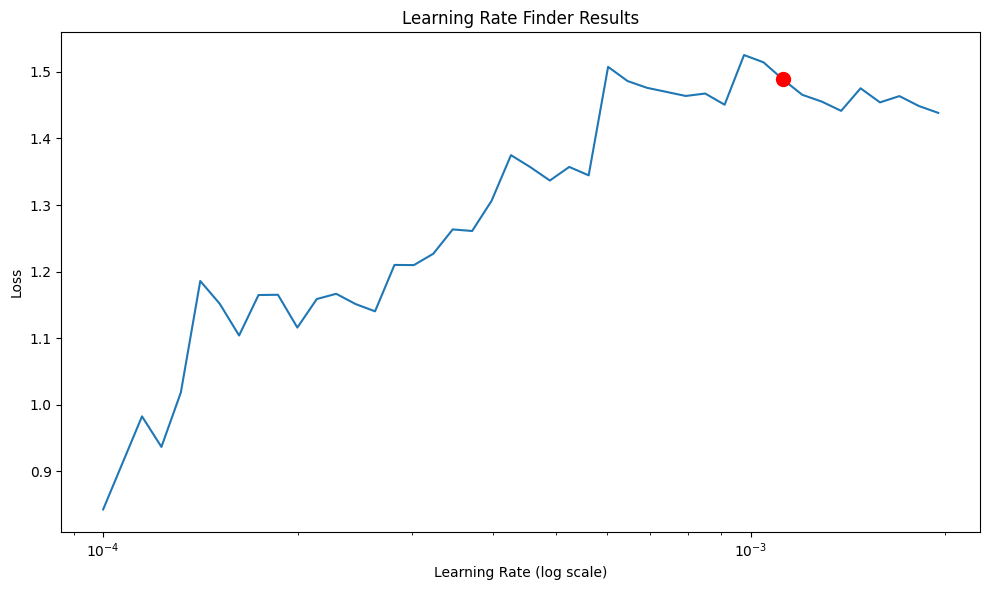

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  38%|███▊      | 38/100 [00:01<00:01, 36.65it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 42 steps due to diverging loss.
Finding best initial lr:  42%|████▏     | 42/100 [00:01<00:01, 35.78it/s]
Learning rate set to 0.0005248074602497726
Restoring states from the checkpoint path at /U

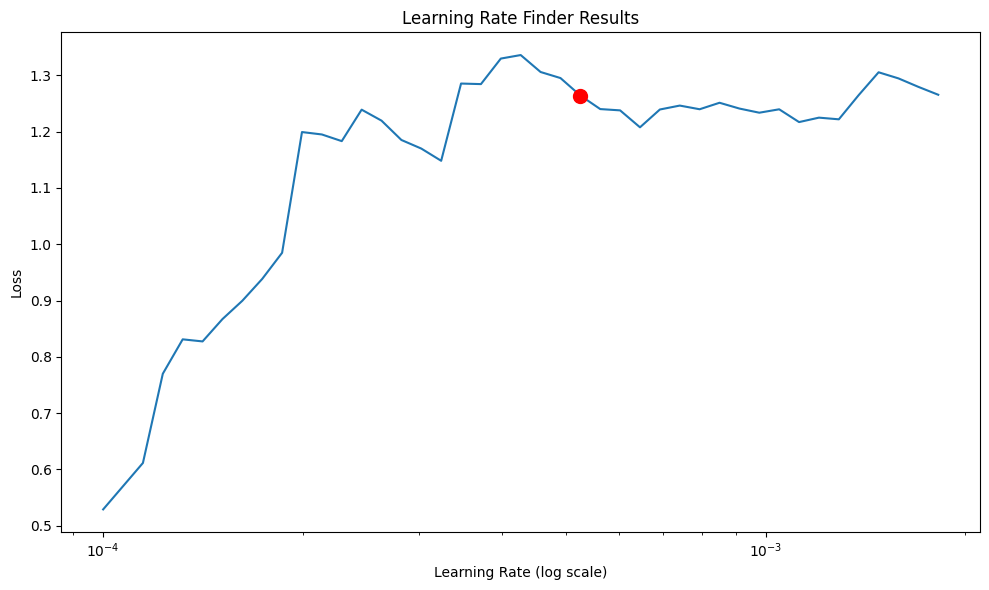

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00052481


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 116.47it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 116.45it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

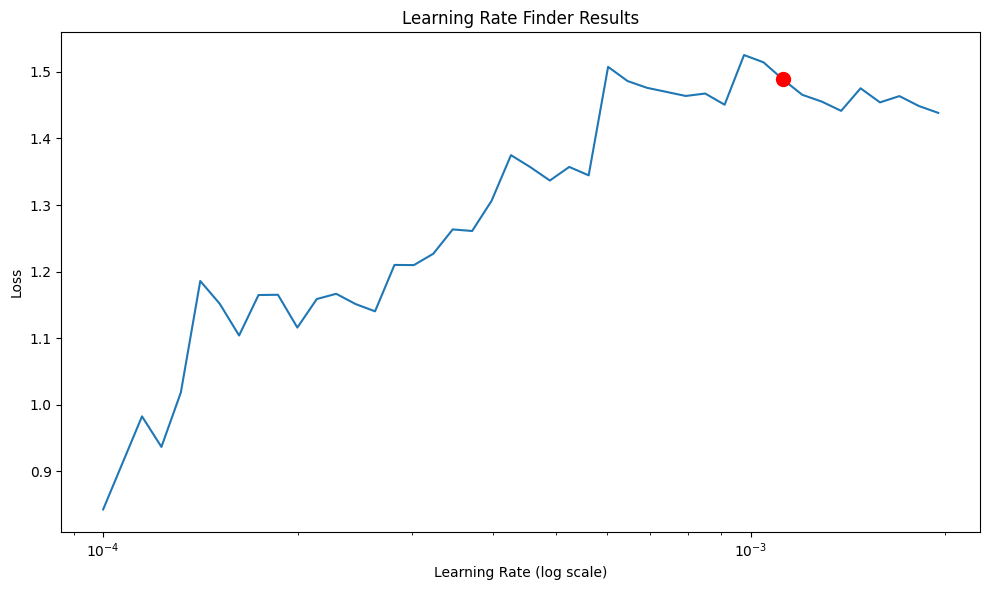

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 115.69it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 114.08it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at

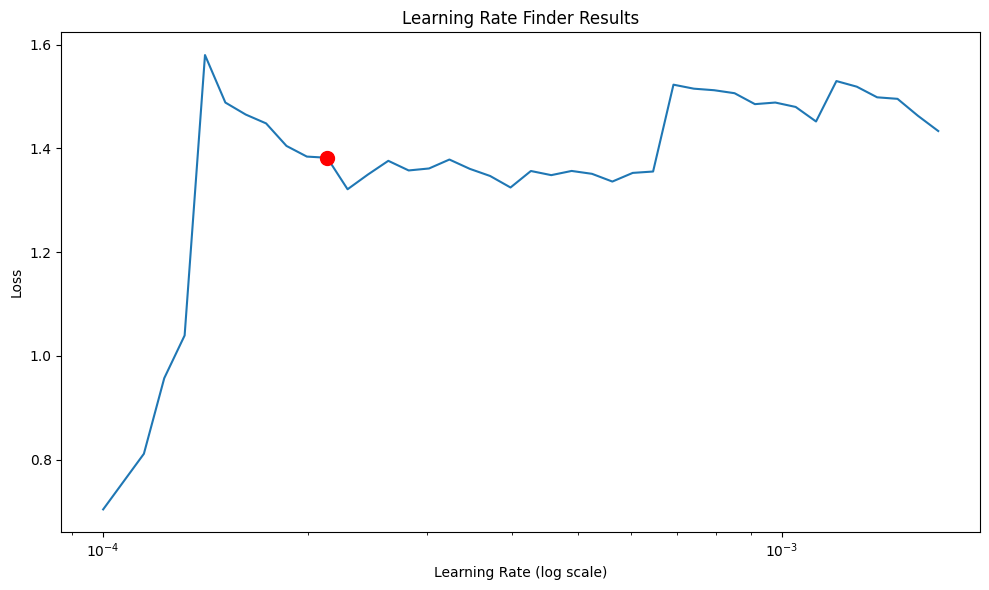

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  37%|███▋      | 37/100 [00:00<00:00, 118.09it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 117.32it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

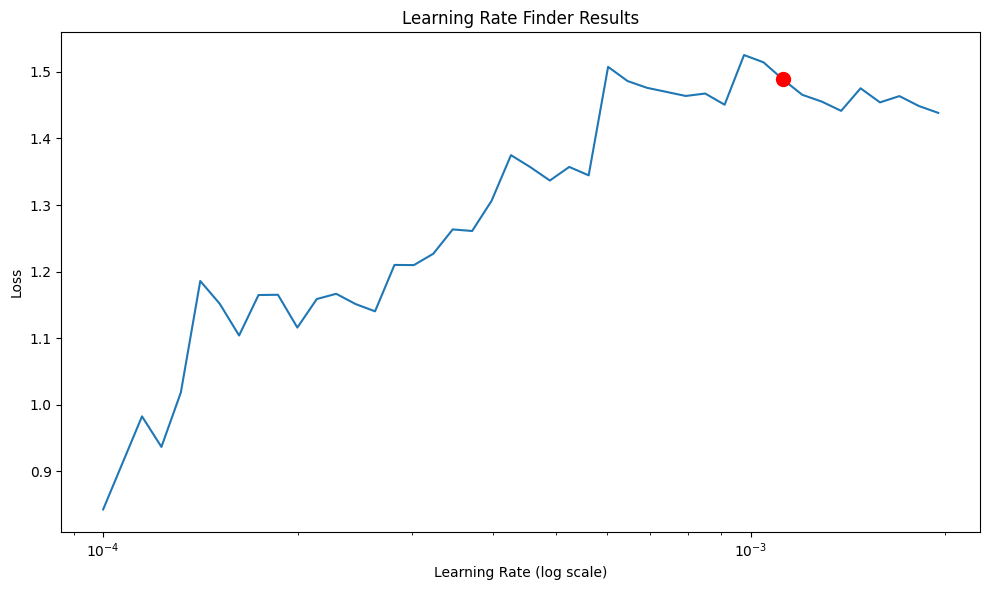

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 113.39it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 112.46it/s]
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at

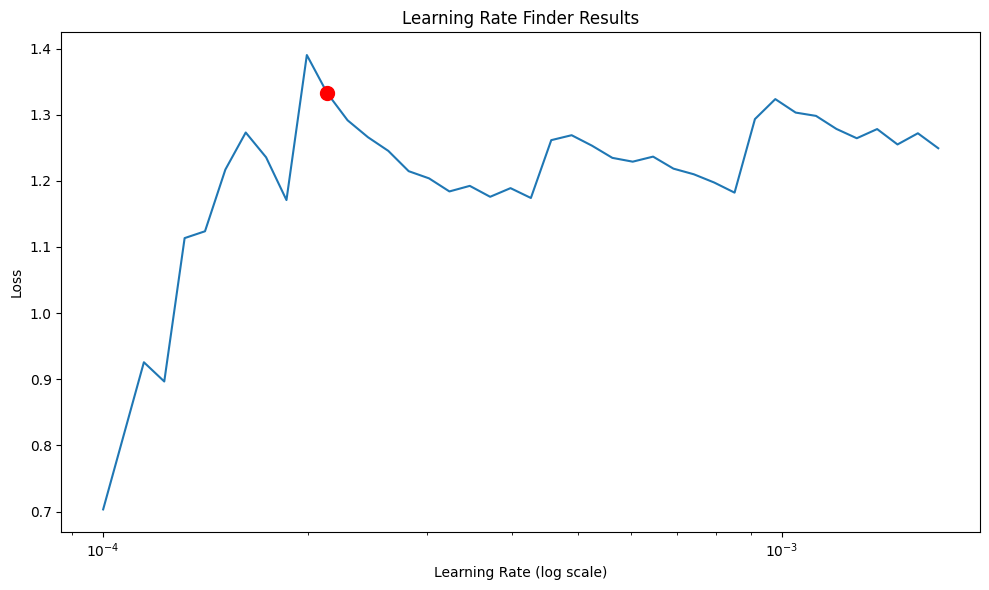

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00021380


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  37%|███▋      | 37/100 [00:00<00:00, 118.91it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 117.29it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

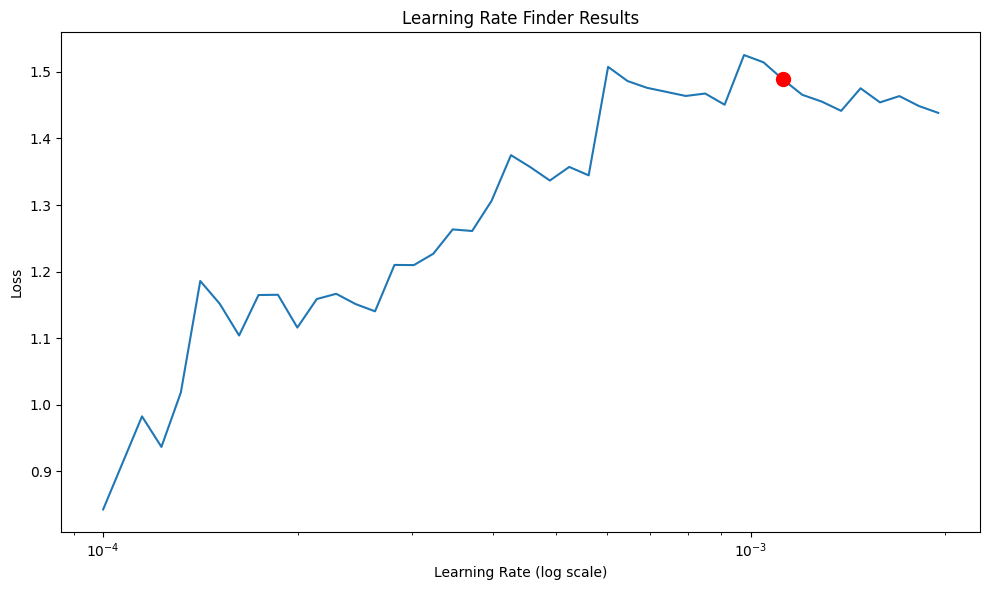

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 117.60it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 115.65it/s]
Learning rate set to 0.0009120108393559099
Restoring states from the checkpoint path at 

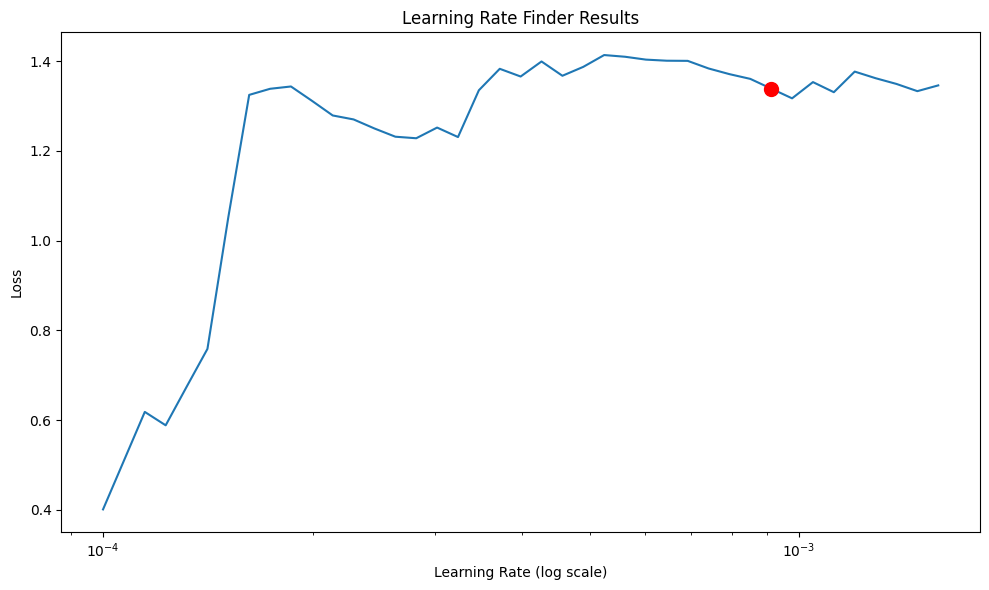

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00091201


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  38%|███▊      | 38/100 [00:00<00:00, 119.21it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 117.61it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

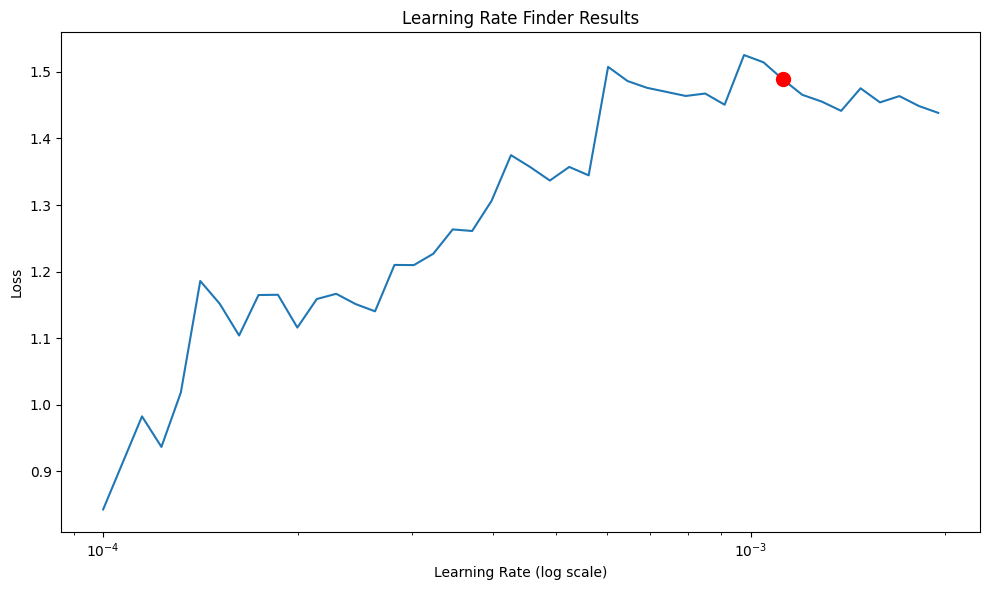

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  37%|███▋      | 37/100 [00:00<00:00, 118.30it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 116.23it/s]
Learning rate set to 0.00024547089156850307
Restoring states from the checkpoint path at

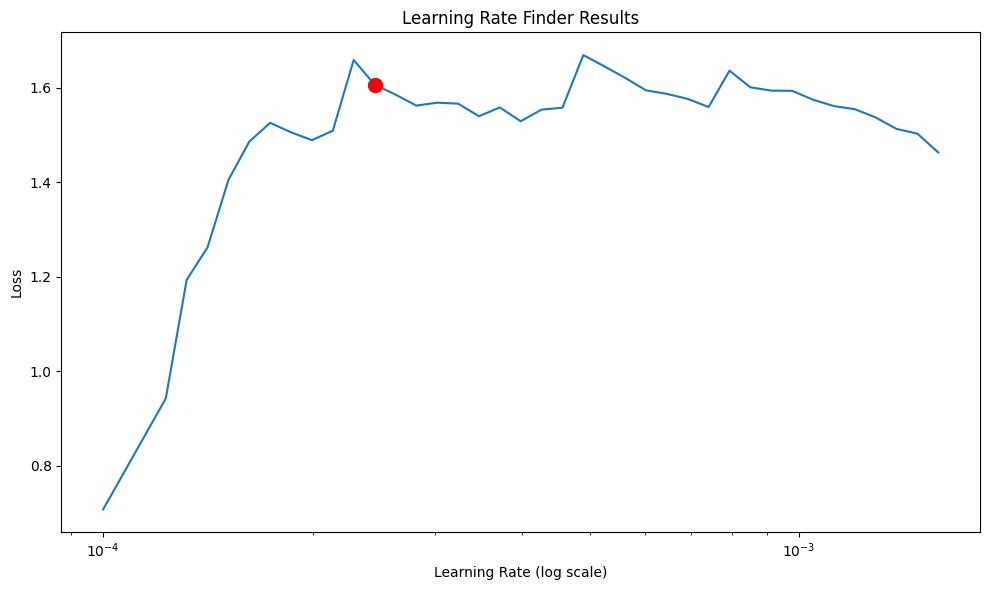

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00024547


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  37%|███▋      | 37/100 [00:00<00:00, 117.68it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 117.30it/s]
Learning rate set to 0.0011220184543019633
Restoring states from the checkpoint path at 

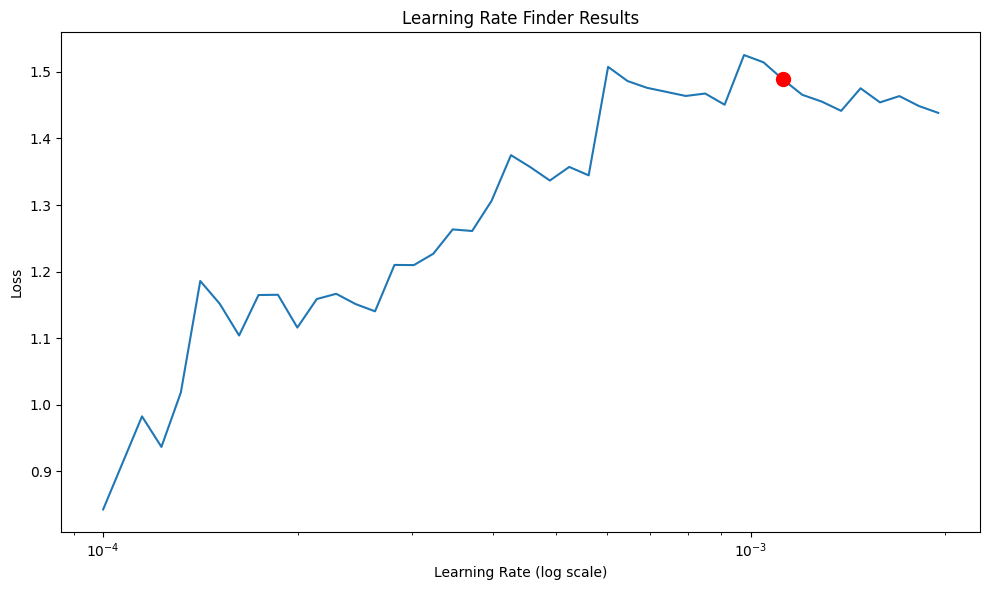

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00112202


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

In [15]:
# pd_errors_df = lstm_error_comparison(final_detrend, lstm_df_window, inputs_window, 'private_debt', lag_range=(1, 7), min_lr=1e-4, max_lr=1e-1, num_epochs=500)


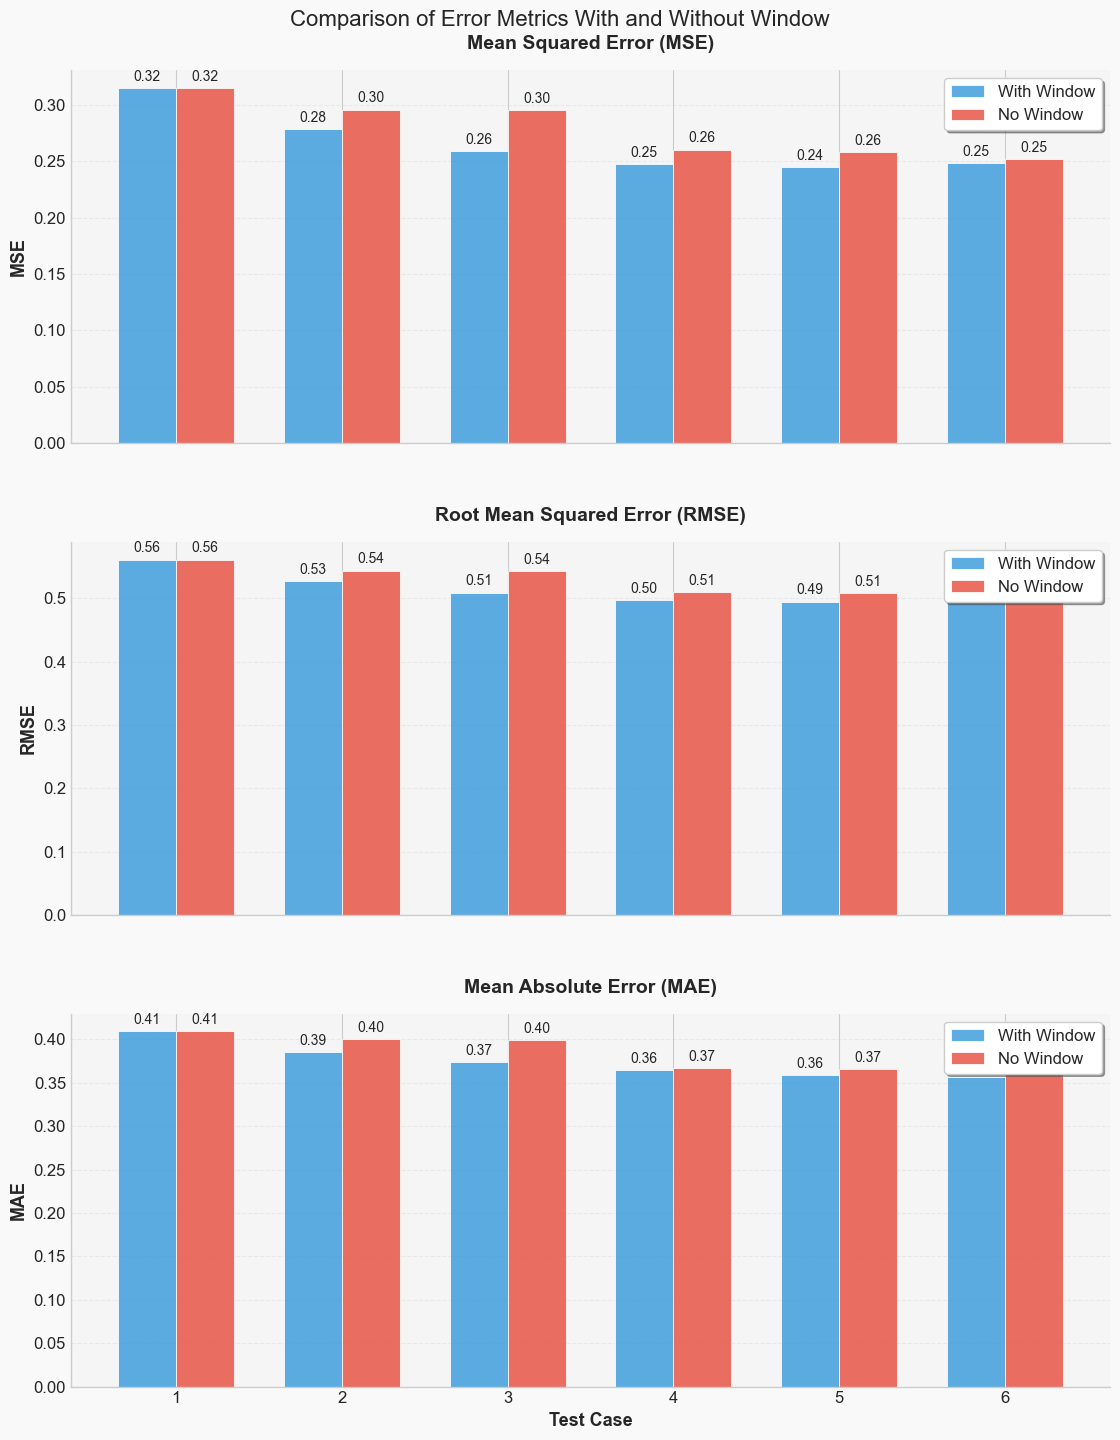

,window_mse,no_window_mse,window_rmse,no_window_rmse,window_mae,no_window_mae
1,0.315140,0.315140,0.561373,0.561373,0.409238,0.409238
2,0.278262,0.295828,0.527506,0.543901,0.385155,0.400081
3,0.259161,0.295414,0.509079,0.543520,0.373593,0.399547
4,0.247131,0.260249,0.497122,0.510146,0.364170,0.367318
5,0.244976,0.258335,0.494950,0.508267,0.358971,0.365785
6,0.247990,0.251898,0.497986,0.501894,0.356564,0.362274


In [16]:

plot_comparison(hhd_errors_df)
hhd_errors_df

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding optimal learning rate...


Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 69.72it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 59.59it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_7c0a3e36-7de6-400f-b0e8-91f2ccdcd4f3.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_7c0a3e36-7de6-400f-b0e8-91f2ccdcd4f3.ckpt


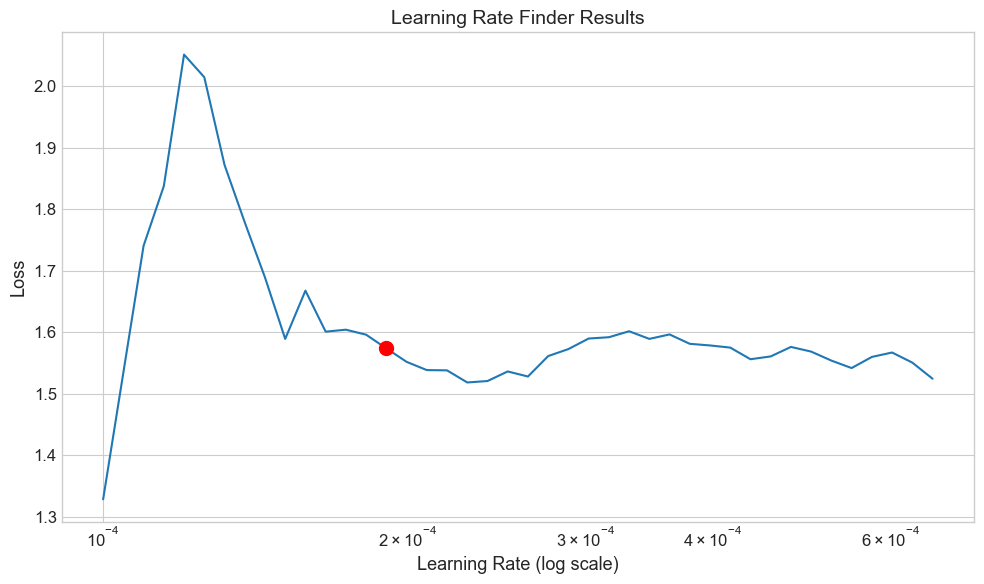

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00019055
Finding optimal learning rate...


Finding best initial lr:  34%|███▍      | 34/100 [00:00<00:00, 87.74it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 79.45it/s]
Learning rate set to 0.00016595869074375607
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_2ab3ee1d-94c7-44f3-adf8-50ee4b8f825f.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_2ab3ee1d-94c7-44f3-adf8-50ee4b8f825f.ckpt


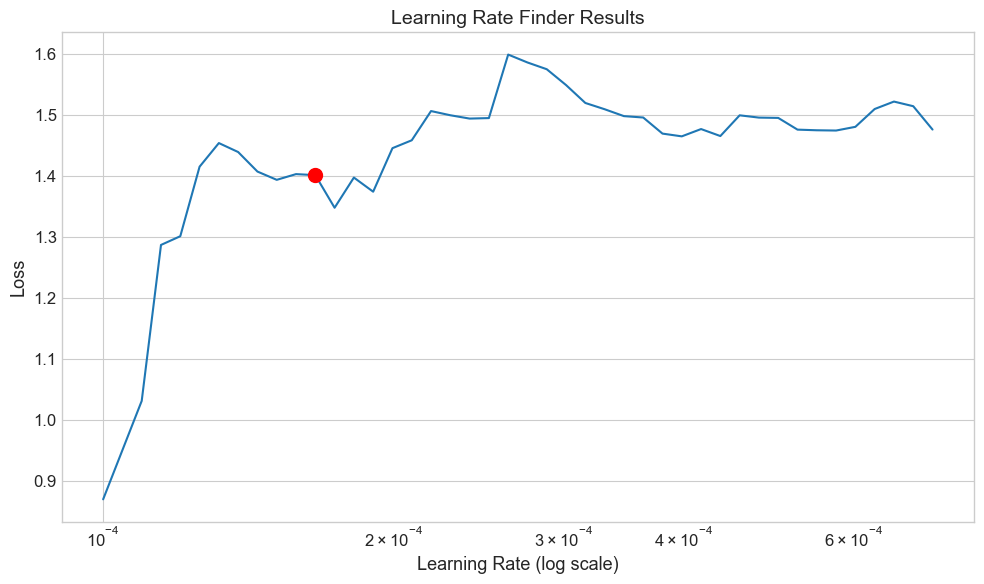

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00016596
Finding optimal learning rate...


Finding best initial lr:  32%|███▏      | 32/100 [00:00<00:00, 102.03it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 98.80it/s] 
Learning rate set to 0.0006309573444801934
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_b14e2c9e-ebd9-48b6-b40f-a7990e62e0c7.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_b14e2c9e-ebd9-48b6-b40f-a7990e62e0c7.ckpt


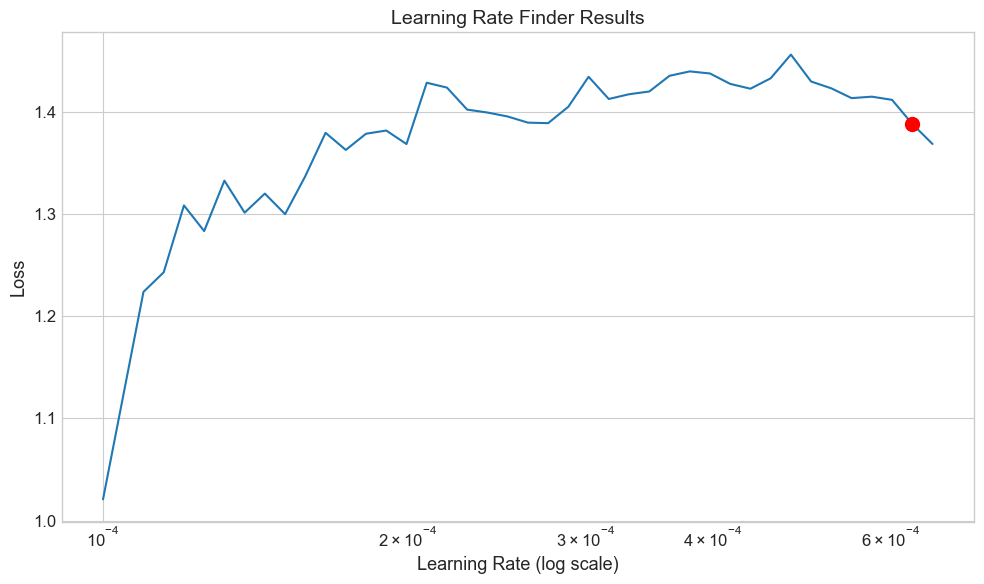

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00063096
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 103.10it/s]
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Finding best initial lr:  39%|███▉      | 39/100 [00:18<00:00, 103.10it/s]

In [19]:
variables = final_detrend.columns
param_dict_window = {}
param_dict_no_window = {}


LAGS = 3
lstm_df= lstm.create_lstm_data(final_detrend, LAGS)

min_lr = 0.0001  
max_lr = 0.01    

for variable in variables:
    best_lr = lstm.find_learning_rate(lstm_df, inputs, f'{variable}', min_lr=min_lr, max_lr=max_lr)
    param_dict_no_window[variable] = {'learning_rate': best_lr, 'epochs': 500}
    best_lr_window = lstm.find_learning_rate(lstm_df_window, inputs_window, f'{variable}', min_lr=min_lr, max_lr=max_lr)
    param_dict_window[variable] = {'learning_rate': best_lr_window, 'epochs': 500}

model_scaler_dict_no_window = deepvar.get_model_and_scaler_no_window(lstm_df, variables, inputs, param_dict_no_window)
model_scaler_dict_window = deepvar.get_model_and_scaler_window(lstm_df_window, variables, inputs_window, param_dict_window, lags=LAGS)


gdp_deepvar_metrics_no_window = deepvar.test_errors(lstm_df, lstm_test, 'log_GDP', model_scaler_dict_no_window, variables, LAGS)
hhd_deepvar_metrics_no_window = deepvar.test_errors(lstm_df, lstm_test,  'household_debt', model_scaler_dict_no_window, variables, LAGS)
fd_deepvar_metrics_no_window = deepvar.test_errors(lstm_df, lstm_test,  'private_debt', model_scaler_dict_no_window, variables, LAGS)


# For the windowed version the lag is always 1 because the window the length of the lag is created model_scaler_dict_window
gdp_deepvar_metrics_windows = deepvar.test_errors(lstm_df_window, lstm_test_window, 'log_GDP', model_scaler_dict_window, variables, 1)
hhd_deepvar_metrics_windows  = deepvar.test_errors(lstm_df_window, lstm_test_window,  'household_debt', model_scaler_dict_window, variables, 1)
fd_deepvar_metrics_windows  = deepvar.test_errors(lstm_df_window, lstm_test_window,  'private_debt', model_scaler_dict_window,variables, 1)



In [ ]:
model_scaler_dict_no_window = deepvar.get_model_and_scaler_no_window(lstm_df, variables, inputs, param_dict_no_window)
model_scaler_dict_window = deepvar.get_model_and_scaler_window(lstm_df_window, variables, inputs_window, param_dict_window, 3)

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Processing lag: 1
  Finding learning rate for log_GDP
Finding optimal learning rate...


Finding best initial lr:  39%|███▉      | 39/100 [00:00<00:00, 89.67it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 89.05it/s]
Learning rate set to 0.00016595869074375607
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_d67a24a6-2146-4d43-b454-29fc6e5e2943.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_d67a24a6-2146-4d43-b454-29fc6e5e2943.ckpt


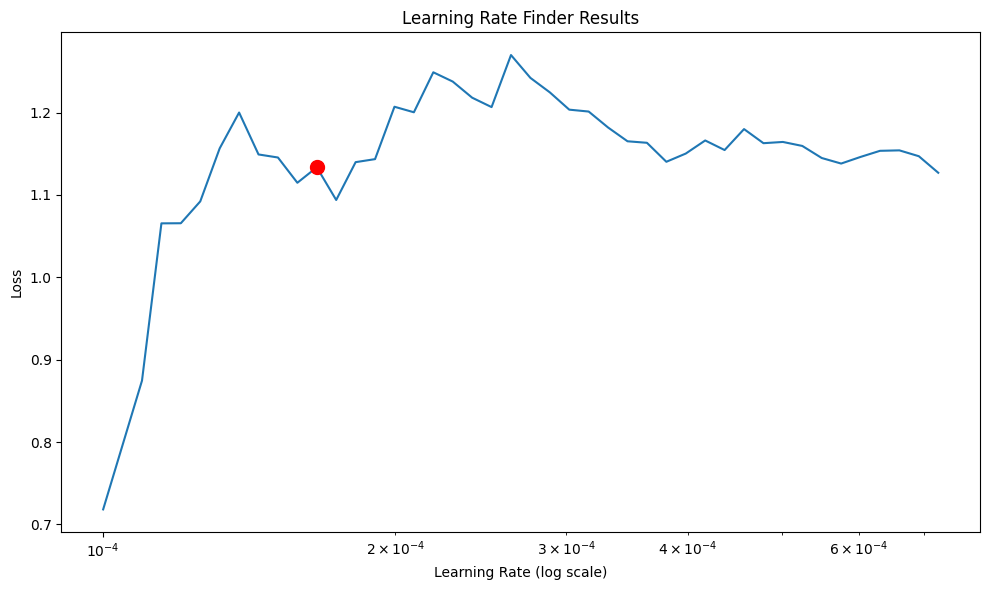

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00016596
Finding optimal learning rate...


Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 81.96it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 81.76it/s]
Learning rate set to 0.00016595869074375607
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_de42ec38-7462-43e6-9314-5a6cbe46eac0.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_de42ec38-7462-43e6-9314-5a6cbe46eac0.ckpt


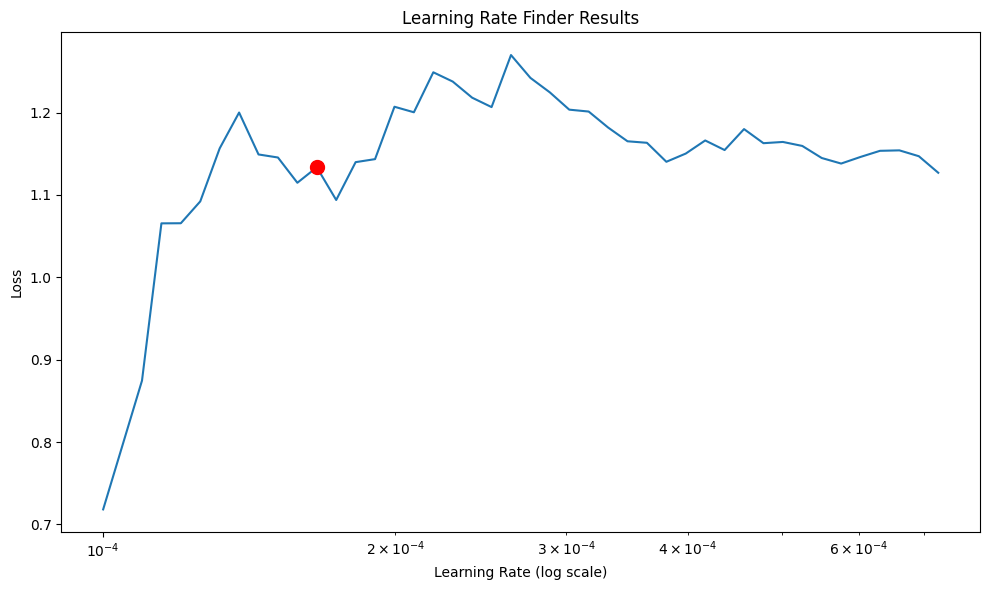

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00016596
  Finding learning rate for household_debt
Finding optimal learning rate...


Finding best initial lr:  35%|███▌      | 35/100 [00:00<00:00, 81.50it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 82.24it/s]
Learning rate set to 0.00047863009232263843
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_aa8b6b45-28b0-4ba2-8615-b2cfdc5cbd5d.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_aa8b6b45-28b0-4ba2-8615-b2cfdc5cbd5d.ckpt


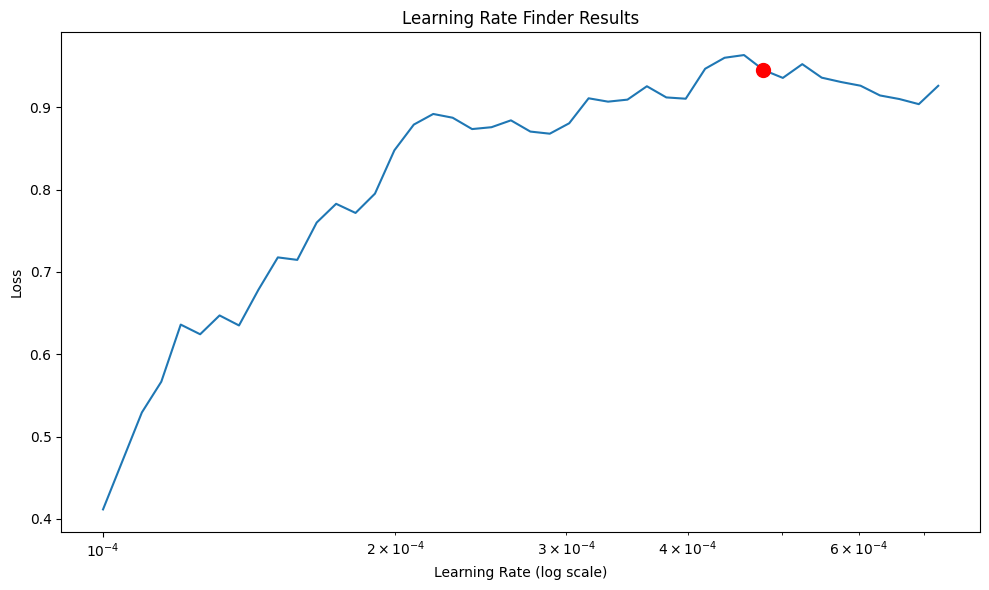

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00047863
Finding optimal learning rate...


Finding best initial lr:  38%|███▊      | 38/100 [00:00<00:00, 91.35it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 89.51it/s]
Learning rate set to 0.00047863009232263843
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_435bad2d-3afa-4580-aa0f-da94084c8490.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_435bad2d-3afa-4580-aa0f-da94084c8490.ckpt


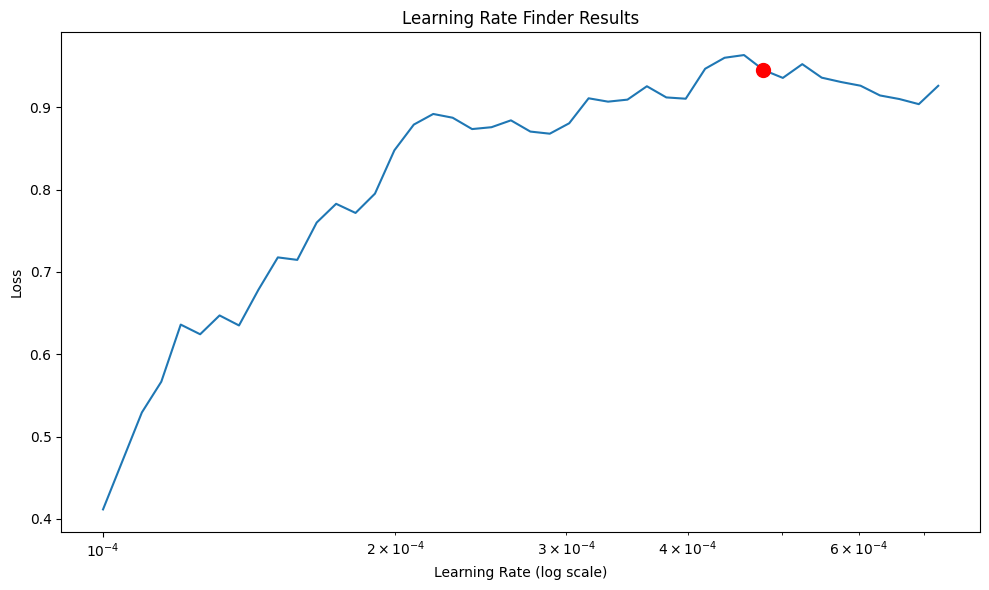

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00047863
  Finding learning rate for private_debt
Finding optimal learning rate...


Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 86.05it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 86.02it/s]
Learning rate set to 0.0005011872336272722
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_fa0c6880-1de7-4d2e-a1e8-573e3c0185aa.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_fa0c6880-1de7-4d2e-a1e8-573e3c0185aa.ckpt


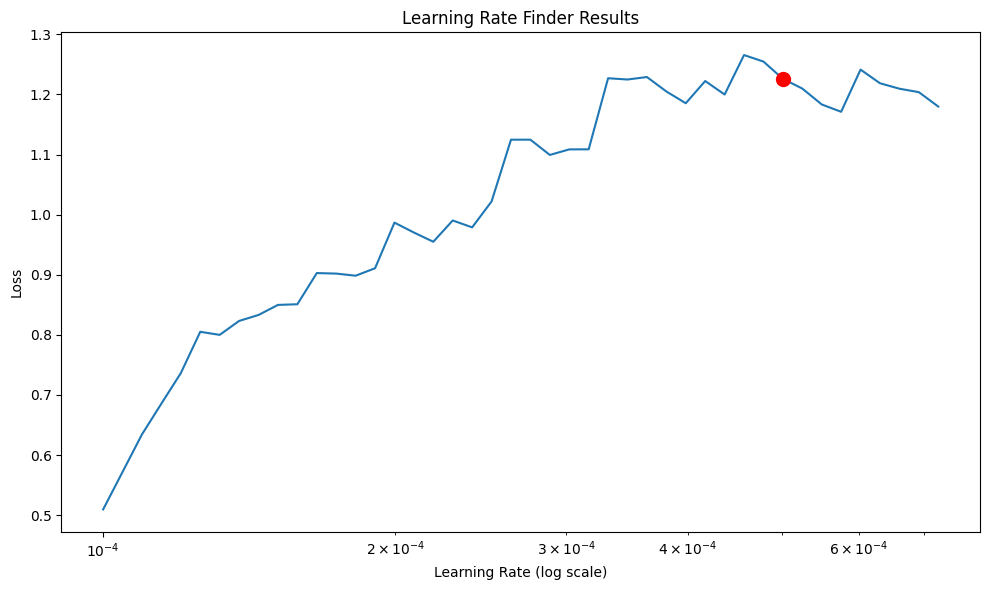

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00050119
Finding optimal learning rate...


Finding best initial lr:  36%|███▌      | 36/100 [00:00<00:00, 86.59it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 83.72it/s]
Learning rate set to 0.0005011872336272722
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_9a733aaa-3de9-4910-8975-7f02b52d251b.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/WindowNoWindow/.lr_find_9a733aaa-3de9-4910-8975-7f02b52d251b.ckpt


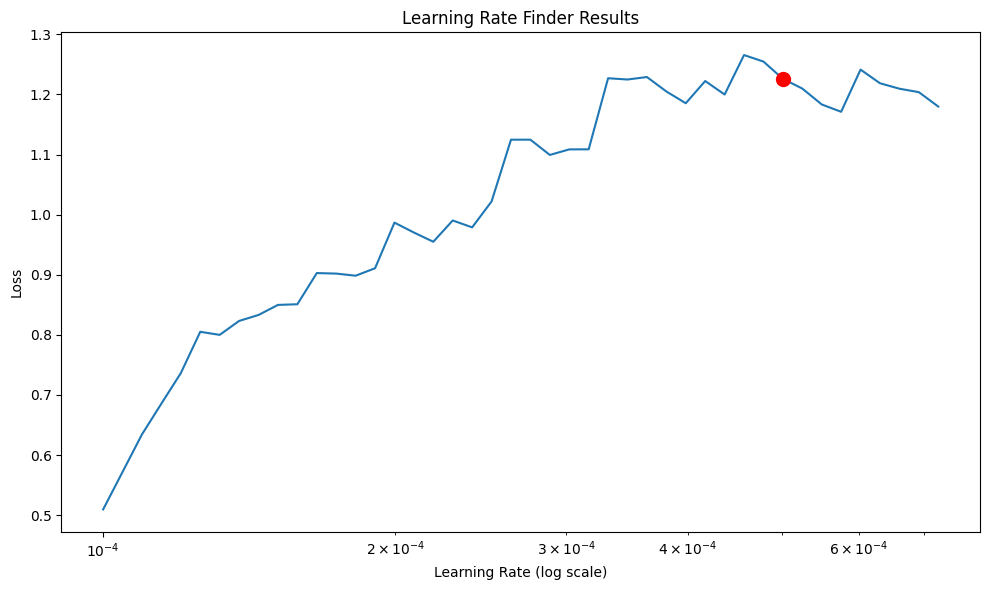

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00050119


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU avai

  Computing metrics for log_GDP


TypeError: test_errors() missing 2 required positional arguments: 'LAG' and 'cross_sectional_means'

In [ ]:
MIN_LAG = 1
MAX_LAG = 6 
lag_range = range(MIN_LAG, MAX_LAG + 1)

results = {
    'log_GDP': {},
    'household_debt': {},
    'private_debt': {}
}

lstm_df_window = lstm.create_lstm_data(final_detrend, 1)
lstm_train_window, lstm_val_window, lstm_test_window= lstm.train_val_test_split(lstm_df_window)
inputs_window = lstm.get_lstm_input(final_detrend, 1)

# Loop through each lag
for lag in lag_range:
    print(f"Processing lag: {lag}")
    
    lstm_df = lstm.create_lstm_data(final_detrend, lag)
    lstm_train, lstm_val, lstm_test= lstm.train_val_test_split(lstm_df)

    
    # Define input features for both approaches
    inputs = [col for col in lstm_df.columns if col not in variables]
    inputs_window = [col for col in lstm_df_window.columns if col not in variables]
    
    # Initialize parameter dictionaries for this lag
    param_dict_no_window = {}
    param_dict_window = {}
    
    # Find optimal learning rates for each variable
    min_lr = 0.0001
    max_lr = 0.01
    
    for variable in variables:
        print(f"  Finding learning rate for {variable}")
        
        # Find best learning rate for no-window approach
        best_lr = lstm.find_learning_rate(lstm_df, inputs, f'{variable}', min_lr=min_lr, max_lr=max_lr)
        param_dict_no_window[variable] = {'learning_rate': best_lr, 'epochs': 500}
        
        # Find best learning rate for window approach
        best_lr_window = lstm.find_learning_rate(lstm_df_window, inputs_window, f'{variable}', 
                                               min_lr=min_lr, max_lr=max_lr)
        param_dict_window[variable] = {'learning_rate': best_lr_window, 'epochs': 500}
    
    # Train models with the optimal parameters
    model_scaler_dict_no_window = deepvar.get_model_and_scaler_no_window(
        lstm_df, variables, inputs, param_dict_no_window)
    model_scaler_dict_window = deepvar.get_model_and_scaler_window(
        lstm_df_window, variables, inputs_window, param_dict_window, lag)
    
    # Calculate error metrics for each variable
    for variable in variables:
        print(f"  Computing metrics for {variable}")
        
        # For no-window approach
        no_window_metrics = deepvar.test_errors(
            lstm_df, lstm_test, variable, model_scaler_dict_no_window, variables, lag, cross_sectional_means, country_means)
        
        # For window approach
        # Note: For the windowed version, the effective lag is always 1 because the window has the length of the lag
        window_metrics = deepvar.test_errors(
            lstm_df_window, lstm_test_window, variable, model_scaler_dict_window, variables, 1)
        
        # Store results
        if lag not in results[variable]:
            results[variable][lag] = {
                'no_window': no_window_metrics,
                'window': window_metrics
            }

def create_error_df(variable_results):
    index = list(variable_results.keys())  # lags as index
    columns = ['no_window_mse', 'no_window_rmse', 'no_window_mae', 
               'window_mse', 'window_rmse', 'window_mae']
    df = pd.DataFrame(index=index, columns=columns)
    
    # Fill the DataFrame with values
    for lag, metrics in variable_results.items():
        df.loc[lag, 'no_window_mse'] = metrics['no_window'][0]
        df.loc[lag, 'no_window_rmse'] = metrics['no_window'][1]
        df.loc[lag, 'no_window_mae'] = metrics['no_window'][2]
        df.loc[lag, 'window_mse'] = metrics['window'][0]
        df.loc[lag, 'window_rmse'] = metrics['window'][1]
        df.loc[lag, 'window_mae'] = metrics['window'][2]
    
    return df

# generate and save error for each variable
error_dfs = {}
for variable in variables:
    error_dfs[variable] = create_error_df(results[variable])
    print(f"\nError metrics for {variable}:")
    print(error_dfs[variable])
    
    error_dfs[variable].to_csv(f"{variable}windowcomp_error_metrics.csv")



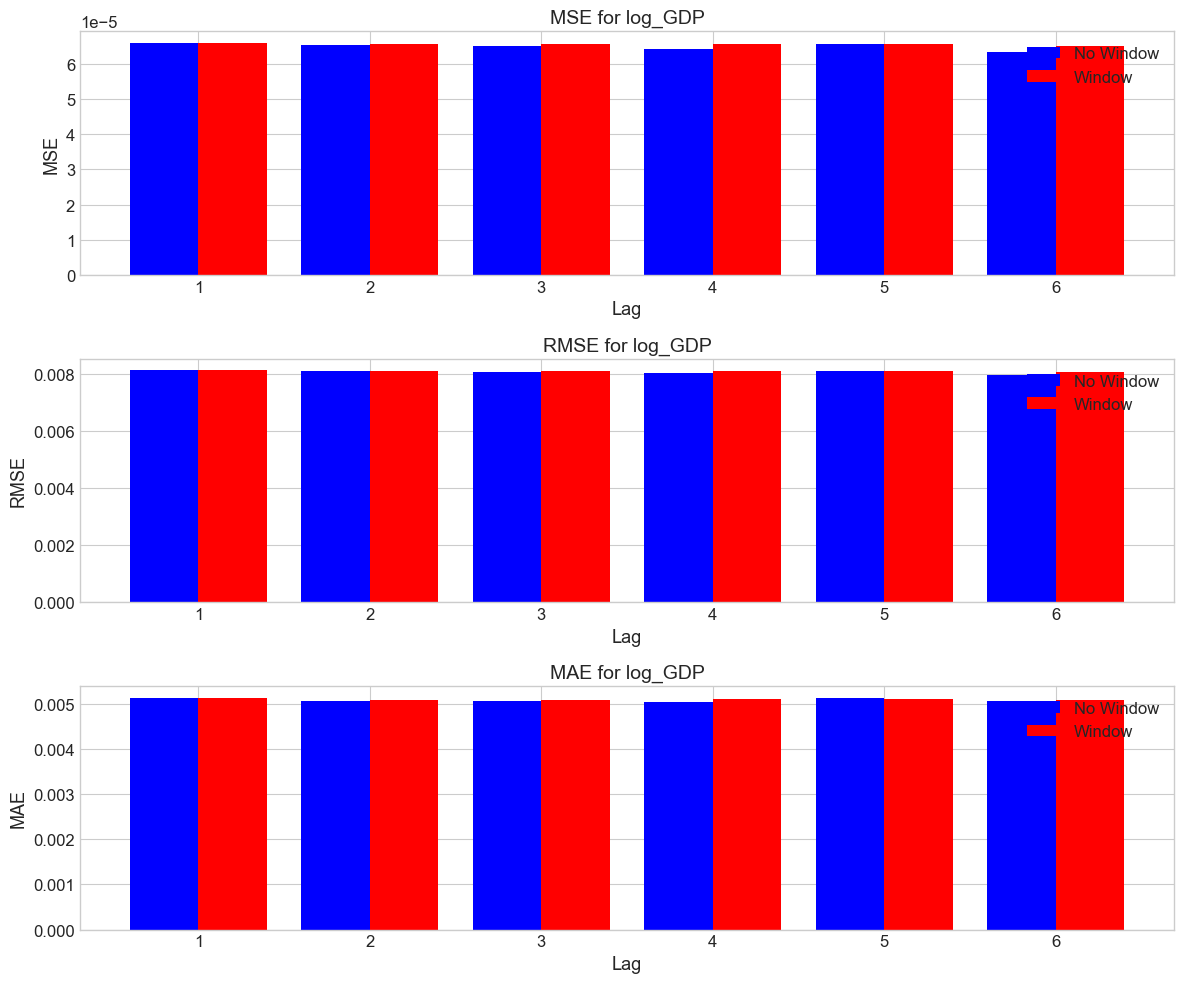

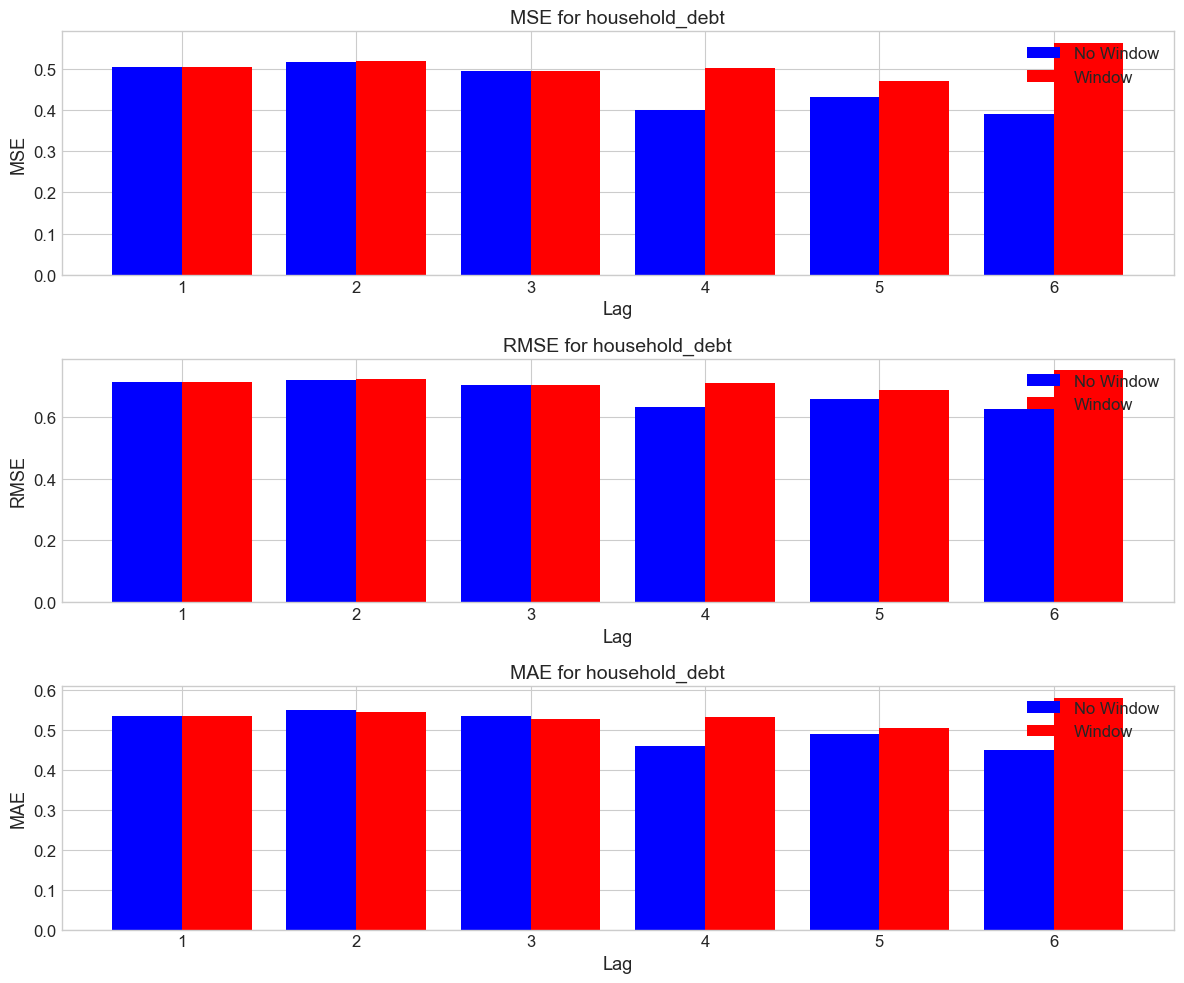

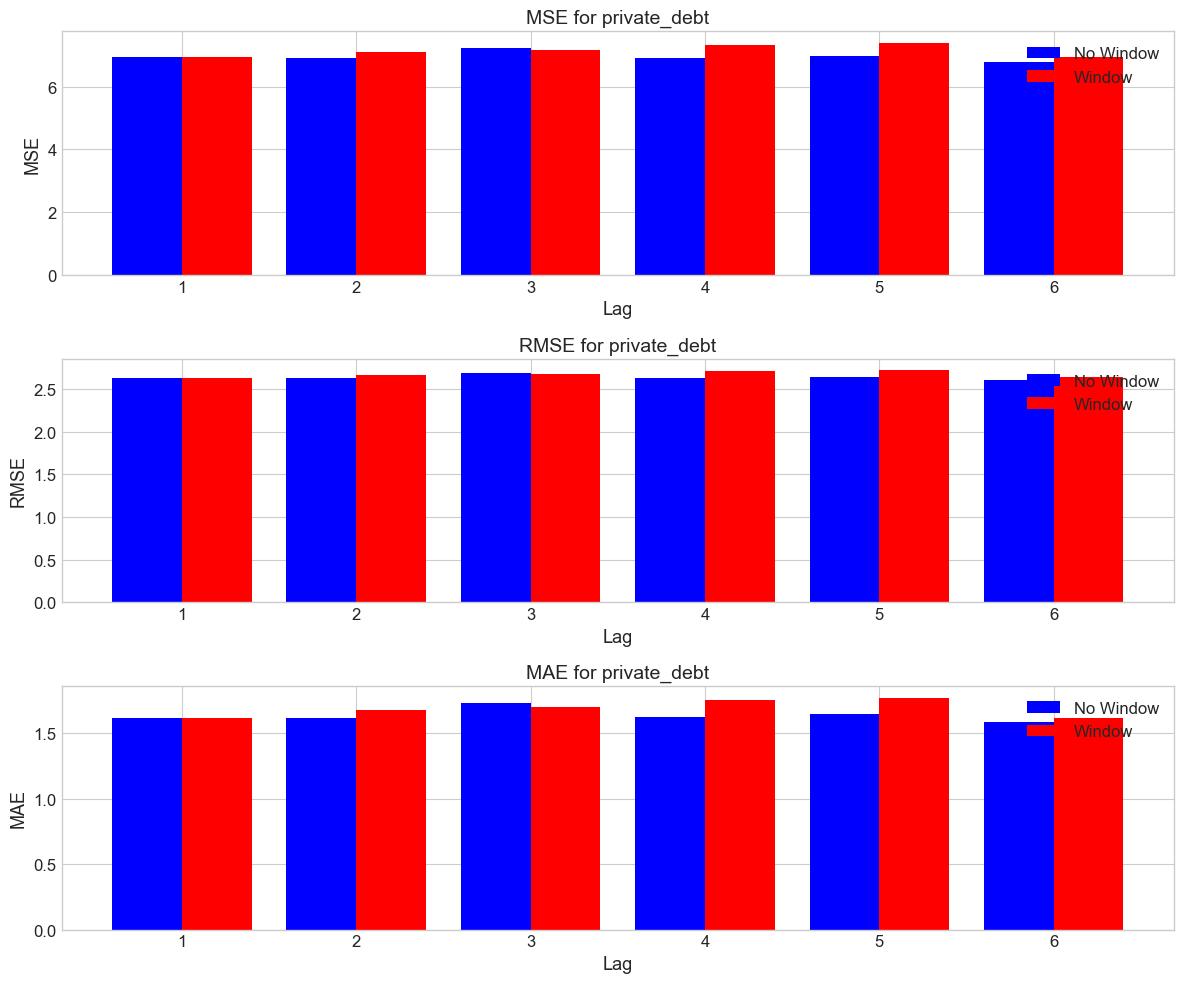

In [ ]:
def plot_error_metrics(variable, error_df):
    plt.figure(figsize=(12, 10))
    
    # Plot MSE
    plt.subplot(3, 1, 1)
    plt.bar(error_df.index - 0.2, error_df['no_window_mse'], width=0.4, label='No Window', color='b')
    plt.bar(error_df.index + 0.2, error_df['window_mse'], width=0.4, label='Window', color='r')
    plt.title(f'MSE for {variable}')
    plt.xlabel('Lag')
    plt.ylabel('MSE')
    plt.legend()
    
    # Plot RMSE
    plt.subplot(3, 1, 2)
    plt.bar(error_df.index - 0.2, error_df['no_window_rmse'], width=0.4, label='No Window', color='b')
    plt.bar(error_df.index + 0.2, error_df['window_rmse'], width=0.4, label='Window', color='r')
    plt.title(f'RMSE for {variable}')
    plt.xlabel('Lag')
    plt.ylabel('RMSE')
    plt.legend()
    
    # Plot MAE
    plt.subplot(3, 1, 3)
    plt.bar(error_df.index - 0.2, error_df['no_window_mae'], width=0.4, label='No Window', color='b')
    plt.bar(error_df.index + 0.2, error_df['window_mae'], width=0.4, label='Window', color='r')
    plt.title(f'MAE for {variable}')
    plt.xlabel('Lag')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{variable}_error_metrics.png")
    plt.show()

for variable in variables:
    plot_error_metrics(variable, error_dfs[variable])



In [ ]:
def gen_latex_table_lstm_errors(df):
    rows = len(df)
    latex_table = [
        r"\begin{table}[htbp]",
        r"  \centering",
        r"  \caption{Comparative Analysis of Error Metrics: LSTM Windowed vs. Non-Windowed Approach}",
        r"  \label{tab:error-metrics}",
        r"  \begin{tabular}{c|cc|cc|cc}",
        r"    \hline",
        r"    \multirow{}{}{\textbf{Lags}} & \multicolumn{2}{c|}{\textbf{MSE}} & \multicolumn{2}{c|}{\textbf{RMSE}} & \multicolumn{2}{c}{\textbf{MAE}} \\",
        r"    \cline{2-7}",
        r"    & \textbf{Window} & \textbf{No Window} & \textbf{Window} & \textbf{No Window} & \textbf{Window} & \textbf{No Window} \\",
        r"    \hline"
    ]

    for i in range(rows):
        lag = i + 1
        row = f"    {lag} & {df['window_mse'][i]:.3f} & {df['no_window_mse'][i]:.3f} & {df['window_rmse'][i]:.3f} & {df['no_window_rmse'][i]:.3f} & {df['window_mae'][i]:.3f} & {df['no_window_mae'][i]:.3f} \\\\"
        latex_table.append(row)

    latex_table.append(r"    \hline")
    latex_table.append(r"  \end{tabular}")
    latex_table.append(r"\end{table}")

    latex_code = "\n".join(latex_table)
    print(latex_code)
gen_latex_table_lstm_errors(lGDP_errors_df)

NameError: name 'lGDP_errors_df' is not defined

In [ ]:
gen_latex_table_lstm_errors(hhd_errors_df)

\begin{table}[htbp]
  \centering
  \caption{Comparative Analysis of Error Metrics: Windowed vs. Non-Windowed Approach}
  \label{tab:error-metrics}
  \begin{tabular}{c|cc|cc|cc}
    \hline
    \multirow{}{}{\textbf{Lags}} & \multicolumn{2}{c|}{\textbf{MSE}} & \multicolumn{2}{c|}{\textbf{RMSE}} & \multicolumn{2}{c}{\textbf{MAE}} \\
    \cline{2-7}
    & \textbf{Window} & \textbf{No Window} & \textbf{Window} & \textbf{No Window} & \textbf{Window} & \textbf{No Window} \\
    \hline
    1 & 0.321 & 0.321 & 0.567 & 0.567 & 0.415 & 0.415 \\
    2 & 0.281 & 0.275 & 0.531 & 0.524 & 0.385 & 0.382 \\
    3 & 0.257 & 0.284 & 0.507 & 0.533 & 0.370 & 0.388 \\
    4 & 0.246 & 0.264 & 0.496 & 0.514 & 0.363 & 0.367 \\
    5 & 0.246 & 0.239 & 0.496 & 0.489 & 0.360 & 0.350 \\
    6 & 0.246 & 0.232 & 0.496 & 0.481 & 0.363 & 0.343 \\
    \hline
  \end{tabular}
\end{table}


/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_60315/3669142308.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row = f"    {lag} & {df['window_mse'][i]:.3f} & {df['no_window_mse'][i]:.3f} & {df['window_rmse'][i]:.3f} & {df['no_window_rmse'][i]:.3f} & {df['window_mae'][i]:.3f} & {df['no_window_mae'][i]:.3f} \\\\"


In [ ]:
gen_latex_table_lstm_errors(pd_errors_df)


\begin{table}[htbp]
  \centering
  \caption{Comparative Analysis of Error Metrics: Windowed vs. Non-Windowed Approach}
  \label{tab:error-metrics}
  \begin{tabular}{c|cc|cc|cc}
    \hline
    \multirow{}{}{\textbf{Lags}} & \multicolumn{2}{c|}{\textbf{MSE}} & \multicolumn{2}{c|}{\textbf{RMSE}} & \multicolumn{2}{c}{\textbf{MAE}} \\
    \cline{2-7}
    & \textbf{Window} & \textbf{No Window} & \textbf{Window} & \textbf{No Window} & \textbf{Window} & \textbf{No Window} \\
    \hline
    1 & 6.804 & 6.804 & 2.608 & 2.608 & 1.566 & 1.566 \\
    2 & 6.466 & 6.691 & 2.543 & 2.587 & 1.503 & 1.528 \\
    3 & 6.051 & 6.770 & 2.460 & 2.602 & 1.475 & 1.568 \\
    4 & 6.034 & 6.849 & 2.456 & 2.617 & 1.461 & 1.584 \\
    5 & 5.850 & 6.613 & 2.419 & 2.572 & 1.435 & 1.531 \\
    6 & 5.582 & 6.765 & 2.363 & 2.601 & 1.515 & 1.549 \\
    \hline
  \end{tabular}
\end{table}


/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_60315/3669142308.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row = f"    {lag} & {df['window_mse'][i]:.3f} & {df['no_window_mse'][i]:.3f} & {df['window_rmse'][i]:.3f} & {df['no_window_rmse'][i]:.3f} & {df['window_mae'][i]:.3f} & {df['no_window_mae'][i]:.3f} \\\\"


In [ ]:
balanced_data = pd.read_csv('./balanced_data.csv')
balanced_data = balanced_data[['country', 'quarter', 'l_GDP_dif', 'hd_dif', 'pd_dif']]
balanced_data = balanced_data.dropna()

balanced_data


,country,quarter,l_GDP_dif,hd_dif,pd_dif
0,Argentina,2008q2,0.003586,0.100000,-1.299999
1,Argentina,2008q3,0.007642,-0.100000,-0.200001
2,Argentina,2008q4,-0.046987,0.200000,0.100000
3,Argentina,2009q1,-0.036652,-0.100000,0.500000
4,Argentina,2009q2,-0.024878,0.000000,0.200001
...,...,...,...,...,...
2413,United States,2022q3,0.006564,-0.299995,-1.200005
2414,United States,2022q4,0.006334,-0.500000,-0.799995
2415,United States,2023q1,0.005548,-1.200005,-0.400002
2416,United States,2023q2,0.005098,-0.399994,-1.000000
